# Introduction to Neural Networks

Written by Rikab Gambhir (Center for Theoretical Physics, MIT)

In this tutorial, we will explore Neural Networks, the fundamental building block of deep learning. We will go into the very basics of the theory of Neural Networks and Universal Function Approximation. Then, we will explore practical immplementations of Neural Networks and deep learning that are widely used both in physics applications and also are widespread in industry.

This tutorial is divided into 4 parts:



1.   **Neural Network Basics**: Constructing multi-layer perceptrons and studying universal function approximation.
2.   **JAX**: An increasingly popular library used for machine learning. This library is extremeley similar to basic numpy, but has extra features like autodifferentiation and compilation that make it useful for machine learning.
3.   **PyTorch**: A commonly used ML library. Developed by Meta. Especially nice for implementing fancy modern ML models, since they're mostly developed in PyTorch anyways!
4.   **Tensorflow**: Less common in 2025, but many ML tools still use it.





**Prerequisites**

I will assume knowledge of the following:
1. Basic python and numpy. You should be comfortable with matrix operations within numpy, dealing with lists and loops, defining functions, and classes.
2. You are familiar with the previous tutorials on regression, classification, normalizing flows, and unsupervised learning. In particular you should appreciate the idea of finding parameters that minimize the log-likelhood (or other metrics) for function fitting, and the general importance of finding/optimizing for functions for statistical tasks.

# Chapter 1: Neural Network Basics

In [1]:
# Standard Imports
import os
import sys
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In previous tutorials, e.g. [regression](https://colab.research.google.com/github/mcgen-ct/tutorials/blob/main/ml/regression.ipynb), the goal was to model a fixed functional form $f(x)$ where $f$ depended on some parameters $\theta$. For example, a linear fit of the form $f(x) = \theta_0 + \theta_1 x$.

In Deep Learning, we want to be more ambitious. We do not want to assume a specific fucntional form: rather than only ``searching'' over linear functions, we want to search over *all* functions, or at least a very large class of functions. Our strategy for doing this is to take a functional form with an extremeley large set of parameters, such that in the infinite parameter limit all functions of a particular class fit within the parameterization. For example. the set of functions:

\begin{align}
f(x) = \sum_{i=0}^N \theta_i x^i
\end{align}

models all one-dimension analytic functions as $N \to \infty$. However, we would like a more general parameterization that can work for many dimensions and even model non-smooth (or even non-continuous) functions arbtirarily well.

A **Neural Network (NN)**  (also known as a **Multilayer Perceptron (MLP)** a **feedforward network**, or a **Dense Neural Network (DNN)** depending on the context) parameterizes *all* peicewise-continuous functions from $\mathbb{R}^{n} \to \mathbb{R}^m$ arbitrarily well with a very simple parameterization.


To define a neural network, we first specify $L-2$ integers $N_1, ..., N_{L-1}$. Just for notation, choose $N_0 = n$ as the input dimension, and $N_L = m$ as the output dimension. $L$ is referred to as the *depth* of the network (or number of layers), and the $N$'s are the *width* of each layer. Unless you are doing something fancy (e.g. autoencoders), it is typical to choose $N$ to all be the same.

Then, we define a set of *layer functions*, which are maps $f^{\ell}:\mathbb{R}^{N_{\ell-1}}\to\mathbb{R}^{N_{\ell}}$, as:

$$ f^{\ell}(x) = \sigma(W^{(\ell)}x + b^{(\ell)})$$

where $W^{(\ell)} \in \mathbb{R}^{N_{\ell} \times N_{\ell -1}}$ and $b^{(\ell)} \in \mathbb{R}^{N_{\ell}}$ are the parameters that define the layer, and $\sigma$ is some pre-determined nonlinear transformation. This can differ between layers, but it is common to chose $\sigma$ to be the same for every layer except the last, where $\sigma$ is often instead chosen such that its image matches the desired output space. An extremeley common and simple chose for $\sigma$ is the ReLU (Rectified Linear Unit) function, which we will use throuhout the rest of this tutorial:

$$ \sigma(x) = \max(0, x)$$

Then, the full neural network is defined by:

$$ f = f^{L} \cdot f^{L-1} \cdot ... \cdot f^{1}$$

Let's make an MLP from scratch!

In [6]:

# Building a Neural Network from Scratch #

input_dim = 2
output_dim = 1


L = 3
N = 16 # We will use the same N throughout for simplicity


# Function to initialize the W's and b's
# For now, lets just pick random numbers!
def init_params(input_dim, output_dim, L, N):

  Ws = []
  bs = []

  for l in range(L):
    if l == 0:
      W = np.random.randn(N, input_dim) / np.sqrt(input_dim)
      b = np.random.randn(N) / np.sqrt(input_dim)
      # The sqrt(input_dim) normalization is not important for our toy examples, but it is common to do for stability reasons

    elif l == L-1:
      W = np.random.randn(output_dim, N) / np.sqrt(N)
      b = np.random.randn(output_dim) / np.sqrt(N)

    else:
      W = np.random.randn(N, N) / np.sqrt(N)
      b = np.random.randn(N) / np.sqrt(N)

    Ws.append(W)
    bs.append(b)

  return Ws, bs

# Implement the ReLU function
def sigma(x):

  return np.maximum(0, x)


In [7]:

# Function to evaluate a neural network given x, the weights W, and the biases b

def MLP(x, Ws, bs):

  y = x.copy()

  for l in range(L):

    # Fun python fact: "@" implements matrix multiplication!
    y = Ws[l] @ y + bs[l]

    # Don't apply sigma to the final output so that our answer isn't forced positive
    if l != L - 1:
      y = sigma(y)

  return y

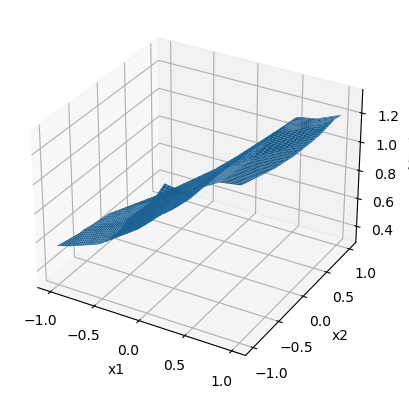

In [8]:
# Test our MLP function by graphing the function f:R2 -> R1

# Define some test points in R2
xs1 = np.linspace(-1, 1, 100)
xs2 = np.linspace(-1, 1, 100)

xs1, xs2 = np.meshgrid(xs1, xs2)

# Initialize the weights and biases
Ws, bs = init_params(input_dim, output_dim, L, N)

ys = []
for x in zip(xs1.flatten(), xs2.flatten()):
  x = np.array(x)
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)
ys = ys.reshape(xs1.shape)

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs1, xs2, ys)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y = MLP(x)')
plt.show()





**A note on functional vs. object-oriented programming**

In the above code, we defined our MLP purely using python functions. There is no neural network "object" with an internal state keeping track of the parameters. Instead, the parameters $W$ and $b$ are also treated as inputs to functions. This is *functional programming*, in which there are no objects with internal states that get modified. This is the approach to ML used by JAX.

It is also possible to define an MLP *class*, which is an object that contains the parameters as internal states that can potentially be modified, and methods that implement the model and evaluate $f(x)$. This is the approach to ML used by PyTorch and Tensorflow.

It is largely a matter of programming taste which you prefer. Below, we will see a brief example of the above code, but written in an object-oriented style rather than functional.

In [9]:
class My_MLP_Class():

  def __init__(self, input_dim, output_dim, L, N):

    # Initialize the network arguments
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.L = L
    self.N = N

    # Initialize the network internal state using the same initi function
    self.Ws, self.bs = init_params(input_dim, output_dim, L, N)

  def evaluate(self, x):

    # Just use the same exact function as above
    return MLP(x, self.Ws, self.bs)

  # "Magic Method" that lets us call the class as if it were a function (just syntatic magic)
  def __call__(self, x):

    return self.evaluate(x)


my_MLP = My_MLP_Class(input_dim, output_dim, L, N)

# Access the weights
my_weights = my_MLP.Ws
print("The number of layers is ",len(my_weights), ",Expected 3")

# Evaluate the function
print("f(1,1) = ", my_MLP(np.array([1, 1])))


The number of layers is  3 ,Expected 3
f(1,1) =  [-0.46451777]


**Historical Notes and Semantics**

The case where $L = 2$ (no ``hidden layers'' between the input and output) with the output dimensionality is $1$ is called a perceptron historically. These were introduced with $\sigma$ not as ReLU, but rather:
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$
(the sigmoid function, hence the notation), and were used back in the day as a model of a biological neuron. The neuron "activates" (produces $1$) when $x$ is large, and "deactivates" (produces $0$ when $x$ is small, where $b$ is then a bias. For this reason, $\sigma$ is called an activation function. This is also why our models are called "Neural Networks". The "network" is because the parameters of the weight matrix $w_{ij}$ are drawn as lines connecting a node $i$ in the previous layer to a node $j$ in the next layer. It's important to remember though, that these are just affine transformations interleaved by some simple nonlinear functions, and there isn't really anything magic here, just slightly-nonlinear algebra.

The name "feedforward" network just refers to the function-compositional aspect of the model. It is to be contrasted with a "backwards pass", where derivatives with respect to the network are actually computed in reverse-order due to chain-rule simplifications. The name "dense" neural network is to emphasize that this is the simplest possible network one can build. There are many modern models with additional properties (such as gauranteeing symmetries, or working in spaces other than simple vector spaces, or deliberately constraining the function space), but many of these can be reduced to very large MLPs with constrained weights. When we say "dense" or "fully-conencted" MLPs, we typically mean there are no constraints on the parameters.



## Chapter 1.1: Universal Function Approximation


The power of MLPs is that they are an efficient way to parameterize a large class of functions. This is captured by the **Universal Function Approximation Theorem(s) (UFAT)** (there are lots of variants, but at the level of rigor we are working at, we won't worry about this).

**Emotionally**, the UFAT tells us that for sufficiently large $N$ and $L$, an MLP can approximate any (reasonable) $n$-to-$m$ dimensional function arbitrarily well.

**Slightly more precisely**, a version of UFAT says: For any piecewise-continuous function $f: \mathbb{R}^n \to \mathbb{R}^m$ defined on a compact domain $D \subset \mathbb{R}^n$, and for any "error tolerance" $\epsilon  > 0$, there exists a large enough $N$ and $L$ such that one can define an MLP with specially-chosen parameters $W$ and $b$ such that:
$$ \int_D dx |f(x) - MLP(x)| < \epsilon $$
i.e. that we have approximated the function to within the specified error.

[Side note: It is actually always possible to do this with just $L$ = 3 (meaning just one hidden layer with chosen $N$ in our defined $L$ counting), but typically this requires an exponentially large $N$ and isn't of practical use for what we will be doing].


We will not prove the UFAT. However, we will explore a weaker-version of it that is easier to understand: If instead we explore continuous-and-piecewise-once-differentiable functions rather than just piecewise-continuous, then there is an easy construction using ReLU networks. If a function is piecewise-once-differentiable, then it can be well-approximated by a piecewise-linear function. We will see below (as exercises) how ReLU networks can exactly reproduce piecewise linear functions.

#### Exercise: Modeling |x|


Given $f(x) = |x|$ in 1 dimension, design an MLP with a choice of N, L, weights W, and biases b that *exactly* match $f(x)$.

HINT: It is possible to do this with $L = 2$ (one hidden layer) and $N = 2$.

HINT 2: It is possible to do this with $b = 0$.



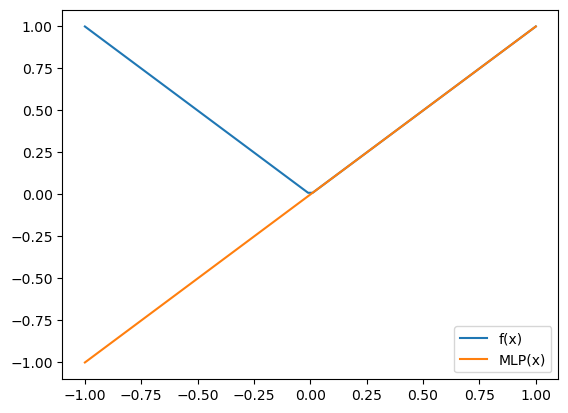

In [10]:
###START_EXERCISE
def f(x):
  return np.abs(x)


L = 0# YOUR SOLUTION HERE
N = 0# YOUR SOLUTION HERE

Ws = [] # YOUR SOLUTION HERE
bs = [] # YOUR SOLUTION HERE

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()

###STOP_EXERCISE

###START_SOLUTION

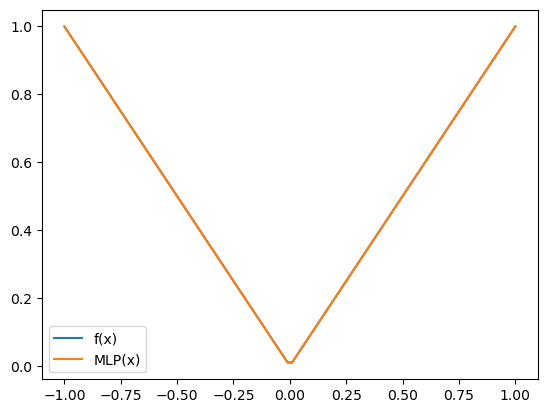

In [11]:
def f(x):
  return np.abs(x)


L = 2
N = 2

W0 = np.array([[ 1.0],      # hidden unit 1:  +x
               [-1.0]])     # hidden unit 2:  –x
b0 = np.array([0.0, 0.0])   # no shift

W1 = np.array([[1.0, 1.0]]) # add the two ReLU outputs
b1 = np.array([0.0,])        # no shift

Ws = [W0, W1]
bs = [b0, b1]

xs = np.linspace(-1, 1, 100)

# Evaluate the solution
ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))

ys = np.array(ys)

# Plot
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


###STOP_SOLUTION

### Exercise: Approximating a smooth 1D function.

Given $f(x) = \sin(10x) \exp(-2x^2)$ on the interval $[-1,1]$, design an MLP with ReLU-activations that approximates the function to within an error of $\epsilon < 0.01$ (where error is the mean-absolute error, as defined above). As a bonus, your implementation should be systematically improvable, e.g. it should be straightforward to make the MLP bigger to reduce the error further. Don't cheat and use minimization to get the parameters, explicitly construct them!


HINT: First construct a continuous piecewise linear appoximation to the function, then implement this piecewise linear function as an MLP. It is possible to do this without knowledge of the actual form of $f$.

HINT 2: This is possible to do systematically with $L = 2$ as before, but with a very large $N$. My personal solution requires $N$ between 100 and 150.

HINT 3: A peicewise-linear continuous function can be written as $f(x) = c_0 + m_0x + + \sum_{j = 1}^{n-1}(m_j - m_{j-1})\sigma(x - x_j)$, where $\sigma$ is ReLU, $x_{1}...x_{n-1}$ are the internal breakpoints, $m_j$ are the slopes to the right of each breakpoint, and $c_0$ is the $y$-coordinate at the leftmost point.




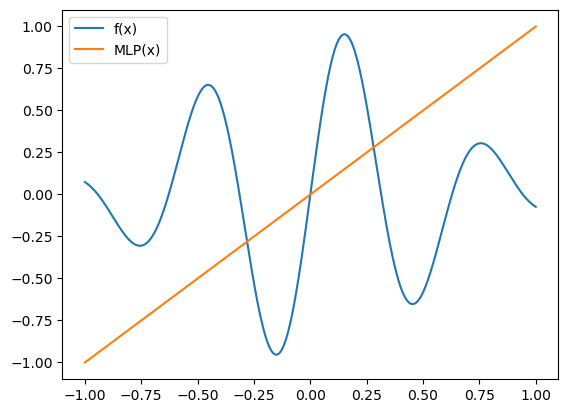

Mean absolute error:  0.6724999748408913


In [12]:
###START_EXERCISE
def f(x):
  return np.sin(10*x) * np.exp(-2*x**2)

L = 0# YOUR SOLUTION HERE
N = 0# YOUR SOLUTION HERE
Ws = [] # YOUR SOLUTION HERE (hint, define a function to construct Ws, bs, systematically)
bs = [] # YOUR SOLUTION HERE


xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()

# Approximate the mean absolute error
print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs)))) #[:,0] due to annoying indexing
###STOP_EXERCISE

###START_SOLUTION

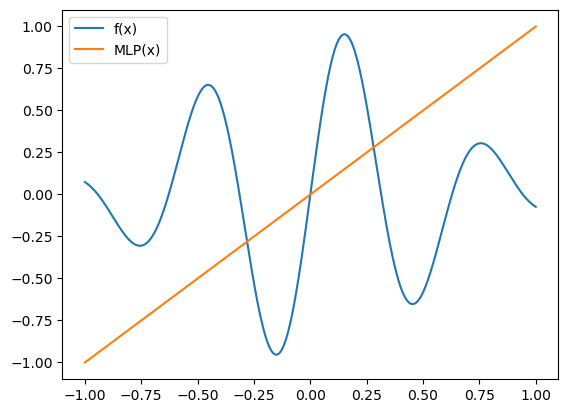

Mean absolute error:  0.6724999748408913


In [13]:

# For any function f, define a piecewise-linear approximation with n breakpoints.
def piecewise_linear_params(n, f):

    # Breakpoints of the piecewise linear approximation
    xk = np.linspace(-1.0, 1.0, n + 1)          # x0, …, xn
    yk = f(xk)

    # Approximate the slopes numerically (technically, possible exactly)
    mk = np.diff(yk) / np.diff(xk)              # m0 … m_{n-1}

    # slope jumps delta_m_j at each breakpoint
    dm = mk[1:] - mk[:-1]

    # constant term that glues the first segment to y(-1)
    c0 = yk[0] - mk[0] * xk[0]

    # Initialize weights
    N = n + 1 # annoying indexing
    W0 = np.ones((N, 1))
    b0 = np.zeros(N)

    # Add and subtract a ReLU, like the |x| example
    W0[0, 0]  =  1.0 ;  b0[0]  = 0.0
    W0[1, 0]  = -1.0 ;  b0[1]  = 0.0

    # interior break-points
    for j, t_j in enumerate(xk[1:-1], start=2):   # j = 2 … n
        W0[j, 0] =  1.0
        b0[j]    = -t_j   # shift to next break point

    # Second layer where everything is just 1 and -1 to add and subtract
    W1 = np.zeros((1, N))
    W1[0, 0] =  mk[0]       #  +m0·ReLU(x)
    W1[0, 1] = -mk[0]       #  −m0·ReLU(−x)

    for j, d_m in enumerate(dm, start=2):
        W1[0, j] = d_m

    b1 = np.array([c0])  # constant offset for leftmost point


    Ws = [W0, W1]
    bs = [b0, b1]
    return Ws, bs


num_breakpoints = 100 # Increase for more accuracy!
Ws, bs = piecewise_linear_params(num_breakpoints, f)
xs = np.linspace(-1, 1, 1000)

ys = []
for x in xs:
  x = np.array([x])
  ys.append(MLP(x, Ws, bs))
ys = np.array(ys)

plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, ys, label='MLP(x)')
plt.legend()
plt.show()


print("Mean absolute error: ", np.mean(np.abs(ys[:,0] - f(xs))))


###END_SOLUTION

## Chapter 1.2: Functional Optimization

We now have the ability to approximate function spaces with MLP's! The fun part of Machine Learning (the Learning) comes in when we can phrase problems as *functional optimization* problems:

"Out of all the (reasonably nice) functions from $\mathbb{R}^n \to \mathbb{R}^m$ , which function $f$ minimizes the loss functional $L[f]$?"

Almost every interesting problem in life, statistics, and physics can be phrased this way. In fact, this is completely identical to Lagrangian mechanics, in the case that $L[f]$ can be written as the integral of a local Lagrangian. In simple cases (ordinary classical mechanics) this functional optimization can be performed using the Euler-Lagrange equations. But in many cases (e.g. where $L[f]$ is written as a sum rather than an integral so EL does not apply, or we can't solve the EL equations, etc), we must settle for numerics.

You have seen in previous tutorials how many statistics problems (e.g. regression, classification, and density estimation) can be seen as functional optimization. In those examples, there were only a few parameters defining the function space: now there are *many* parameters and our function space is as close to the space of all possible functions as possible. We can no longer just use a simple parameter minimizer in this case.

The strategy will be **gradient descent**. If we have an estimate of:
$$\nabla_{\theta}L[f]$$
then by simply moving $\theta$ in the opposite direction of the gradient, we will move towards a local minimum. The process of iterating this is called **training**, and each iteration is called an **epoch**. In statistical settings, where $L[f]$ is some statistical measure (like in the regression examples), this training requires data to obtain statistical estimates of $\nabla_{\theta}L[f]$, hence the need for **training data**. There are many variants of gradient descent that work on the same principle but have varying numerical properties, like stochastic gradient descent and ADAM, but we will not dive deeper into these here.

In principle, if we know $L$ (which we usually do, because it is typically part of the problem specification), we can explictly construct $\nabla_{\theta}L[f]$ exactly, since we know how $f$ depends on our parameters $\theta = (W, b)$. However, it is still painful to manually construct. This is where libraries like **JAX**, **PyTorch**, and **Tensorflow** come in. These libraries are capable of **autodifferentiation**: computations are kept track of in a graph structure, so that gradients can be easily and exactly computed alongside the execution of the function. Exploring this further will be the subject of another tutorial, for now we wil take it for granted that these libraries can perform autodifferentiation.

We have reached the limit of what we can practically do without the use of libraries in a reasonable amount of time. Now, we will explore how to use these libraries.


# Interlude: The problems we will solve:


We will be interested in using Neural Networks to solve classification problems. We have previously seen how to do this with logistic regression and cross-entropies in the [classification tutorial](https://colab.research.google.com/github/mcgen-ct/tutorials/blob/main/ml/classification.ipynb). We will now see how to do this with Neural Networks.

We will have two problems: an easy problem, and a hard problem. The easy problem is "Two Moons", a classic ML test case in 2 dimensions. The hard problem is the "MNIST" dataset, a dataset of handwritten digits that is commonly used to test classification algorithms. This is a 28x28 pixel image dataset, so the input dimension is 784, so MLPs can really shine compared to classical fixed-form regressors.

In [2]:
from sklearn.datasets import make_moons, fetch_openml
from sklearn.preprocessing import StandardScaler

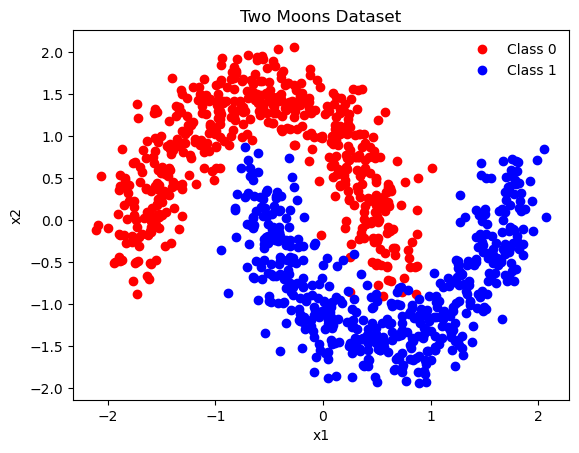

In [3]:
# Two Moons Dataset

X_moons, y_moons = make_moons(1024, noise=0.15, random_state=0)
X_moons = StandardScaler().fit_transform(X_moons) # Just normalizing the data

plt.plot(X_moons[y_moons==0, 0], X_moons[y_moons==0, 1], 'ro', label='Class 0')
plt.plot(X_moons[y_moons==1, 0], X_moons[y_moons==1, 1], 'bo', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Two Moons Dataset')
plt.legend(frameon = False)

/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Example MNIST Digit (7)')

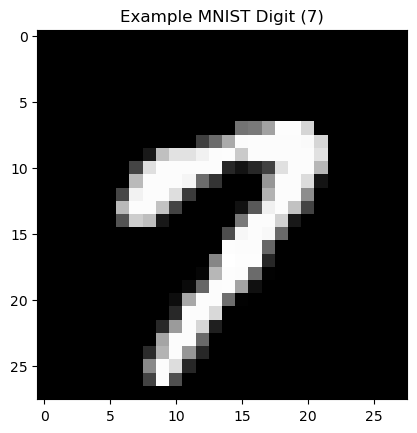

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = mnist.data / 255.0  # Normalize pixel values to [0, 1]
y_mnist = mnist.target.astype(int)  # Convert target to integers

# The MNIST input dimension is 784, but we can visualize it as 28x28 images
plt.imshow(X_mnist[y_mnist == 7][0].reshape(28, 28), cmap='gray')
plt.title('Example MNIST Digit (7)')


# Chapter 2: JAX

JAX is a library developed by Google that is very similar to numpy, but with some extra features that make it useful for machine learning. It is based on the idea of functional programming, where functions are first-class citizens and can be passed around like any other object. JAX is particularly useful for machine learning because it has built-in support for autodifferentiation, which allows us to compute gradients of functions with respect to their inputs.

Compared to PyTorch and Tensorflow, JAX is more low-level and requires more manual work to set up. However, it is also more flexible and allows for more control over computations. JAX is particularly useful for research and experimentation, where you want to try out new ideas quickly without having to worry about the details of the implementation.



In [100]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import time

## Chapter 2.1: JAX basics; vmapping, autodifferentiation, and compilation.

JAX has three useful features that we should be aquainted with:


1.   Vmapping: We can write a function acting on a single variable, and then execute that function on an entire list at once without using loops. In fact, this is much faster than looping (in Python), since Python loops must wait for the previous iteration to finish. Note that numpy can technically do this too, but it becomes especially important in JAX
2.   Just-In-Time compilation (JIT): Python is a scripted language, meaning lines of code are carried out as your computer sees them. In compiled languages, the computer looks at the entire program, translates to machine code (compilation), then executes. You pay an up-front time cost for the initial compilation, but every subsequent execution is much faster since the machine code is typically highly optimized. JIT allows us to pre-compile functions in Python. The cost is that we have to be a little be conscious of things like memory, and we cannot use things like ordinary if-statements or for-loops.
3. Autodifferentiation: If we write a function in JAX, we can automatically compute its exact derivative. We don't have to manually compute it ourselves! This even works with multi-variate functions, functions that are highly-composed and require lots of chain-ruling, etc.



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Loop time:  1.3776862621307373
Vmap time:  0.06246590614318848
Compilation time:  0.015182256698608398
JIT loop time:  0.967613935470581
JIT vmap time:  0.014248847961425781


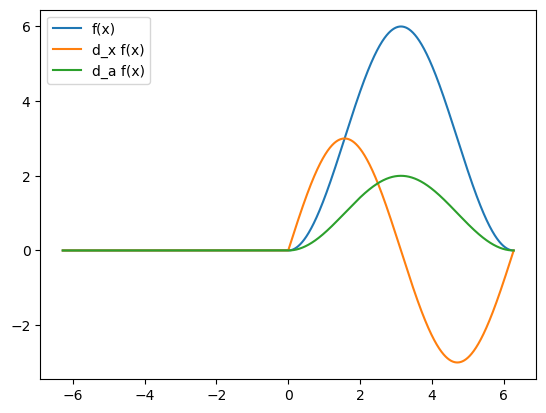

In [18]:
def relu(x):
  return jnp.maximum(0, x)

def theta(x):
  return (x > 0)

def f(x, a):
  return a * (1 - jnp.cos(x)) * theta(x)

a = 3.0
xs = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 10000)

# Vmapping time save test:
start_time = time.time()
ys = []
for x in xs:
  ys.append(f(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("Loop time: ", end_time - start_time)

start_time = time.time()

# vmap(f) is a new function with the same signature as f.
# vmap(f, in_axes = (0, None)) means we only want to vectorize over the first argument (x), not the second.

ys = vmap(f, in_axes = (0, None))(xs, a)
end_time = time.time()
print("Vmap time: ", end_time - start_time)


# Compile the function
start_time = time.time()
f_jit = jit(f)
f_jit(0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"
end_time = time.time()
print("Compilation time: ", end_time - start_time)
# Note that compilation is NOT always faster, especially for only simple functions.
# Also machine-dependent!


start_time = time.time()
ys = []
for x in xs:
  ys.append(f_jit(x, a))
ys = jnp.array(ys)
end_time = time.time()
print("JIT loop time: ", end_time - start_time)

start_time = time.time()
ys = vmap(f_jit, in_axes=(0, None))(xs, a)
end_time = time.time()
print("JIT vmap time: ", end_time - start_time)



# Get the exact gradient with respect to x
f_prime = jax.grad(f, argnums=0) # Argnums is the argument we want the gradient of.
f_prime_jit = jit(f_prime)
f_prime_jit(0.0, a).block_until_ready() # Need to run the compiled function once to compile "just in time"

# Get the exact gradient with respect to a
f_prime_a = jax.grad(f, argnums=1) # Argnums is the argument we want the gradient of.
f_prime_a_jit = jit(f_prime_a)


plt.plot(xs, vmap(f_jit, in_axes=(0, None))(xs, a), label='f(x)')
plt.plot(xs, vmap(f_prime_jit, in_axes=(0, None))(xs, a), label='d_x f(x)')
plt.plot(xs, vmap(f_prime_a_jit, in_axes=(0, None))(xs, a), label='d_a f(x)')
plt.legend()
plt.show()



### Exercise: Autodifferentiation Practice


Given an *arbitrary* scalar-valued function $f(x)$, which you know is smooth, write a function that computes the Taylor expansion of $f$ around a point $x_0$ to order $n$. 

Specifically, your function should take as input $f$, $x_0$, and $n$, and return a new function, $f_n$, which is the Taylor expansion of $f$ around $x_0$ to order $n$. The function $f_n$ should take as input a single variable $x$, and return the value of the Taylor expansion at that point.

HINT: Construct a list of functions $f_0, f_1, ..., f_n$ where $f_i$ is the $i$-th derivative of $f$, or equivalently, $f_i$ is the single derivative of $f_{i-1}$. Then evaluate this list of functions at $x_0$ to obtain the coefficients of the Taylor expansion. 



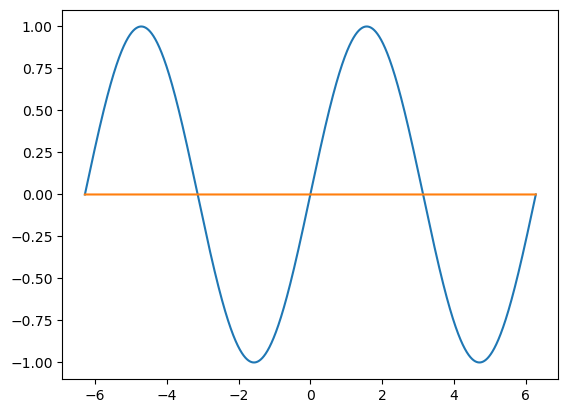

In [19]:
###START_EXERCISE
def f(x):

    # EXAMPLE FUNCTION
    return jnp.sin(x)


def build_taylor_series(f, x0, n):

    # YOUR SOLUTION HERE

    # Define a function representing the solution we want to return
    def taylor_series(x):

        # YOUR SOLUTION HERE
        return 0
        

    return taylor_series


# Test the solution
x0 = 0.0
n = 5  
taylor_series = build_taylor_series(f, x0, n)
xs = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 10000)
plt.plot(xs, f(xs), label='f(x)')
plt.plot(xs, vmap(taylor_series, in_axes=0)(xs), label='Taylor Series')
###STOP_EXERCISE

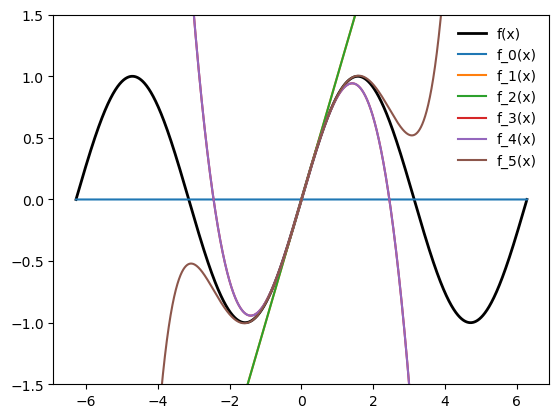

In [20]:
###START_SOLUTION
def f(x):

    # EXAMPLE FUNCTION
    return jnp.sin(x)


def build_taylor_series(f, x0, n):

    # Compute the derivatives at x0
    derivative_functions = [f]
    derivatives_at_x0 = [f(x0)]

    for i in range(1, n + 1):
 
        derivative_functions.append(grad(derivative_functions[-1], argnums=0))
        derivatives_at_x0.append(derivative_functions[-1](x0))

    # Define the Taylor series expansion
    def taylor_series(x):
        series = 0.0
        for i in range(n + 1):
            series += derivatives_at_x0[i] * (x - x0) ** i / np.math.factorial(i)
        return series
    

    return taylor_series


# Test the solution
x0 = 0.0
n = 5  
xs = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, 10000)
plt.plot(xs, f(xs), label = r'f(x)', color = "black", lw = 2)

for i in range(n + 1):
    taylor_series = build_taylor_series(f, x0, i)
    plt.plot(xs, vmap(taylor_series, in_axes=0)(xs), label='f_{}(x)'.format(i))
plt.ylim(-1.5, 1.5)

plt.legend(frameon=False)
###STOP_SOLUTION

## Chapter 2.2: End-to-End MLP and Training from Scratch

First, let's reproduce the MLP we defined above, but now using JAX. We will use the functional programming style, so we will define our MLP as a function that takes in the parameters $W$ and $b$ as inputs.

A small difference is that rather than having W and b as separate inputs, we will combine them into a single input called `params`. This is just for convenience to make taking gradients cleaner. Also, since we are interested in classification, we will use a sigmoid activation for the last layer in the binary classification case to ensure the output is between 0 and 1, which is useful for classification tasks, and use a softmax for the multiclass case.

In [21]:
# JAX MLP. Basically identical to the above numpy code.
def MLP_jax(x, params):
    y = x
    Ws, bs = params

    for l in range(len(Ws) - 1):
        y = jnp.dot(Ws[l], y) + bs[l]
        y = relu(y)

    y = jnp.dot(Ws[-1], y) + bs[-1]  # No activation on the last layer

    return y

# Our classifier will be an MLP with a sigmoid at the end. Change to softmax for multi-class classification.
def classifier(x, params):

    # Its common to call the input to the sigmoid the "logits". But really its the log-likelihood ratio of the classes.
    logits = MLP_jax(x, params)
    return 1 / (1 + jnp.exp(-logits))  


# Gradient with respect to the parameters
classifier_grad = grad(classifier, argnums=1)  


# Initialize the parameters for the MLP
def init_params_jax(input_dim, output_dim, L, N):
    Ws = []
    bs = []

    for l in range(L):
        if l == 0:

            # Basically the same as the numpy version, but using JAX's random module.
            # Unlike numpy, JAX's random module is functional and requires a PRNG key.
            W = random.normal(random.PRNGKey(l), (N, input_dim)) / jnp.sqrt(input_dim) 
            b = random.normal(random.PRNGKey(l + 1), (N,)) / jnp.sqrt(input_dim)
        elif l == L - 1:
            W = random.normal(random.PRNGKey(l), (output_dim, N)) / jnp.sqrt(N) 
            b = random.normal(random.PRNGKey(l + 1), (output_dim,)) 
        else:
            W = random.normal(random.PRNGKey(l), (N, N)) / jnp.sqrt(N) 
            b = random.normal(random.PRNGKey(l + 1), (N,)) 

        Ws.append(W)
        bs.append(b)

    return Ws, bs

Shape of xs:  (10000, 2)


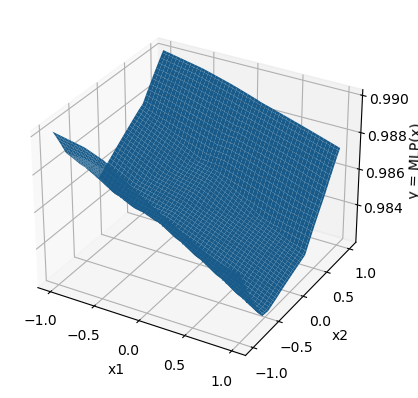

In [22]:
# Test just to make sure it works

N = 16
L = 3
input_dim = 2
output_dim = 1

xs1 = jnp.linspace(-1, 1, 100)
xs2 = jnp.linspace(-1, 1, 100)

xs1, xs2 = jnp.meshgrid(xs1, xs2)
xs = jnp.array(list(zip(xs1.flatten(), xs2.flatten())))
print("Shape of xs: ", xs.shape)  # Should be (10000, 2)

# Initialize the weights and biases
Ws, bs = init_params_jax(input_dim, output_dim, L, N)

# VMAP our model. We can also JIT it, but its actually better to JIT the entire training step function later.
vmapped_classifier = vmap(classifier, in_axes=(0, None))
vmapped_classifier_grads = vmap(classifier_grad, in_axes=(0, None))

ys = vmapped_classifier(xs, (Ws, bs))
ys = ys.reshape(xs1.shape)

# 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs1, xs2, ys)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y = MLP(x)')
plt.show()


Now we set up the training. We want to minimize the cross-entropy loss function, which is defined as:
$$ L[f] = -\frac{1}{N} \sum_{i=1}^{N} y_i \log(f(x_i)) + (1 - y_i) \log(1 - f(x_i)) $$

where $y_i$ is the true label for the $i$-th data point, and $f(x_i)$ is the model score for the $i$-th data point.

We will use JAX's autodifferentiation to compute the gradient of the loss function with respect to the parameters, and then use gradient descent to update the parameters.

<!- -->

In [23]:
# Define the BCE loss
def bce_loss(x, y_true, params):

    y_pred = vmapped_classifier(x, params).squeeze()
    epsilon = 1e-10  # Small value to avoid log(0), just in case
    return -jnp.mean(y_true * jnp.log(y_pred + epsilon) + (1 - y_true) * jnp.log(1 - y_pred + epsilon))


grad_bce_loss = grad(bce_loss, argnums=2)  # Gradient with respect to the parameters


# Gradient step function to update the parameters
@jit  # <- Inline way to JIT the function
def gradient_step(x, y_true, params, learning_rate=0.01):

    # Compute the loss gradients (the loss itself is not needed, just the gradients)
    loss = bce_loss(x, y_true, params) # But we will compute it anyways for logging
    grads = grad_bce_loss(x, y_true, params)

    # Update the parameters using gradient descent
    Ws, bs        = params
    dWs, dbs      = grads
    new_Ws = [W - learning_rate*dW for W, dW in zip(Ws, dWs)]
    new_bs = [b - learning_rate*db for b, db in zip(bs, dbs)]
    new_params = (new_Ws, new_bs)    

    return new_params, loss


# ##### Train the model on the Two Moons dataset #####

# Set the random seed for reproducibility
train_fraction = 0.8
test_fraction = 1- train_fraction
epochs = 2000
learning_rate = 0.1
N = 8 # Its nice to choose N ~ 2^n, since differences in width are only really important on log scale
L = 3

# Split the dataset into training and testing sets
train_size = int(train_fraction * len(X_moons))

# Ensure the dataset is shuffled before splitting
# [Just for fun, try removing this part and see how badly things get ruined]
indices = np.random.permutation(len(X_moons)) 
X_moons = X_moons[indices]
y_moons = y_moons[indices]
X_train, y_train = X_moons[:train_size], y_moons[:train_size]
X_test, y_test = X_moons[train_size:], y_moons[train_size:] 

# Initialize the parameters
params = init_params_jax(input_dim, output_dim, L, N)

# Arrays for saving training info
train_losses = []
test_losses = []

# Train the model
for epoch in range(epochs):

    # Perform a gradient step
    params, loss = gradient_step(X_train, y_train, params, learning_rate)
    train_losses.append(loss)
    # Evaluate on the test set
    test_loss = bce_loss(X_test, y_test, params)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 0, Loss: 0.8957, Test Loss: 0.9008
Epoch 10, Loss: 0.6569, Test Loss: 0.6699
Epoch 20, Loss: 0.4985, Test Loss: 0.4874
Epoch 30, Loss: 0.3992, Test Loss: 0.3823
Epoch 40, Loss: 0.3451, Test Loss: 0.3305
Epoch 50, Loss: 0.3154, Test Loss: 0.3028
Epoch 60, Loss: 0.2990, Test Loss: 0.2877
Epoch 70, Loss: 0.2895, Test Loss: 0.2789
Epoch 80, Loss: 0.2836, Test Loss: 0.2736
Epoch 90, Loss: 0.2796, Test Loss: 0.2700
Epoch 100, Loss: 0.2768, Test Loss: 0.2674
Epoch 110, Loss: 0.2745, Test Loss: 0.2654
Epoch 120, Loss: 0.2726, Test Loss: 0.2636
Epoch 130, Loss: 0.2710, Test Loss: 0.2620
Epoch 140, Loss: 0.2696, Test Loss: 0.2606
Epoch 150, Loss: 0.2682, Test Loss: 0.2593
Epoch 160, Loss: 0.2670, Test Loss: 0.2580
Epoch 170, Loss: 0.2658, Test Loss: 0.2568
Epoch 180, Loss: 0.2646, Test Loss: 0.2556
Epoch 190, Loss: 0.2634, Test Loss: 0.2544
Epoch 200, Loss: 0.2622, Test Loss: 0.2532
Epoch 210, Loss: 0.2609, Test Loss: 0.2519
Epoch 220, Loss: 0.2596, Test Loss: 0.2505
Epoch 230, Loss: 0.258

Shape of xs for contour plot:  (10000, 2)


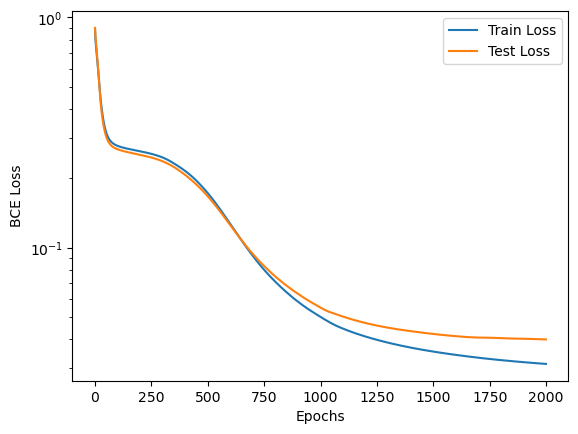

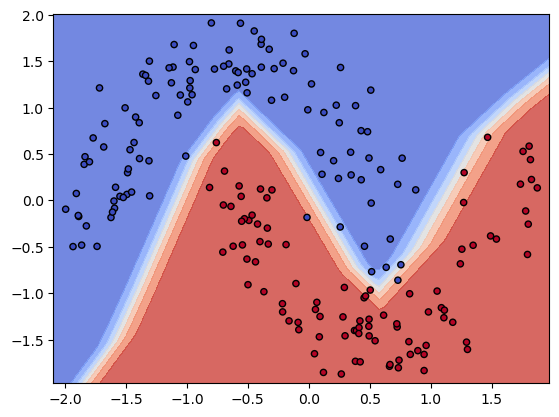

In [24]:
# Plot our answers!

# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log') 
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()

# Plot the decision boundary
fig, ax = plt.subplots()
x_min, x_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1
y_min, y_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1
xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 100), jnp.linspace(y_min, y_max, 100))
xs = jnp.array(list(zip(xx.ravel(), yy.ravel())))
print("Shape of xs for contour plot: ", xs.shape)  # Should be (10000, 2)
Z = vmap(classifier, in_axes=(0, None))(xs, params)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')      
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='o', s=20, cmap='coolwarm')

Congrats! You have coded an MLP from scratch and trained it!

### Exercise 2.1: Ruining the model

In this exercise, we will deliberate try to break the model. The goal here is to get a little experience with failure modes.

Try to deliberately overfit the model. You have a few knobs to play with: The depth $L$, the width $N$, the learning rate, the number of epochs, and the amount of training data. Try to find a combination of these that overfits the training data, i.e. the training loss is very low but the validation loss is high.

Try to see what happens if you forget to shuffle the data! This is a very common mistake. I made this mistake when writing this tutorial, and it took me about 30 minutes to realize why the model was not learning anything.

Try extreme learning rates, like $10^{-6}$ or $10^{2}$. 

When we loaded in the data a few cells ago, we normalized the data. What happens if the data is not O(1)? Try arranging the data so that the inputs are all $O(10^6)$ or $O(10^{-6})$. Technically, the optimal classifier should be coordinate-invariant, but in practice there can be issues! Try some other coordinate transforms of the data too.





In [1]:
###START_EXERCISE
# your solution goes here
###STOP_EXERCISE

###START_SOLUTION

Everything else unchanged, choosing $N \gtrapprox 32$ and $L \gtrapprox 8$ will overfit the training data. There are many other options though!

###STOP_SOLUTION

### Exercise 2.2: MNIST with our JAX MLP

Modify the above code to classify MNIST. You will need to change the loss function and the output activation to account for the fact that MNIST is a multi-class classification problem. 


In [2]:
###START_EXERCISE
# Prepare the MNIST Dataset
train_fraction = 0.8
test_fraction = 1 - train_fraction

# Shuffle the dataset before splitting
indices = np.random.permutation(len(X_mnist))
X_mnist = X_mnist[indices]
y_mnist = y_mnist[indices]
train_size = int(train_fraction * len(X_mnist))
X_train_mnist, y_train_mnist = X_mnist[:train_size], y_mnist[:train_size]       
X_test_mnist, y_test_mnist = X_mnist[train_size:], y_mnist[train_size:]

def one_hot_encode(y, num_classes):
    return jax.nn.one_hot(y, num_classes)

input_dim = 784  # MNIST images are 28x28 pixels, flattened to 784
output_dim = 10  # 10 classes for digits 0-9


# --- The rest of your code here ---
###STOP_EXERCISE

NameError: name 'np' is not defined

###START_SOLUTION

Epoch 0, Loss: 3.1056, Test Loss: 2.8687, Accuracy: 0.0940
Epoch 10, Loss: 2.0985, Test Loss: 2.0521, Accuracy: 0.2913
Epoch 20, Loss: 1.7815, Test Loss: 1.7568, Accuracy: 0.4794
Epoch 30, Loss: 1.5565, Test Loss: 1.5378, Accuracy: 0.5417
Epoch 40, Loss: 1.3772, Test Loss: 1.3613, Accuracy: 0.6101
Epoch 50, Loss: 1.2196, Test Loss: 1.2044, Accuracy: 0.6707
Epoch 60, Loss: 1.0735, Test Loss: 1.0583, Accuracy: 0.7201
Epoch 70, Loss: 0.9374, Test Loss: 0.9227, Accuracy: 0.7596
Epoch 80, Loss: 0.8188, Test Loss: 0.8057, Accuracy: 0.7919
Epoch 90, Loss: 0.7242, Test Loss: 0.7130, Accuracy: 0.8137
Epoch 100, Loss: 0.6520, Test Loss: 0.6422, Accuracy: 0.8316
Epoch 110, Loss: 0.5968, Test Loss: 0.5879, Accuracy: 0.8426
Epoch 120, Loss: 0.5537, Test Loss: 0.5455, Accuracy: 0.8533
Epoch 130, Loss: 0.5193, Test Loss: 0.5116, Accuracy: 0.8624
Epoch 140, Loss: 0.4916, Test Loss: 0.4842, Accuracy: 0.8689
Epoch 150, Loss: 0.4689, Test Loss: 0.4619, Accuracy: 0.8742
Epoch 160, Loss: 0.4502, Test Loss:

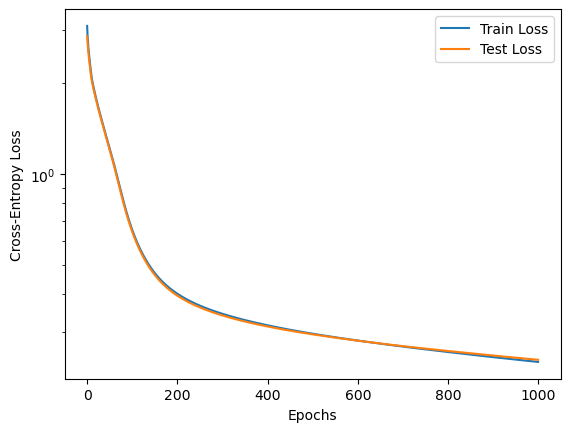

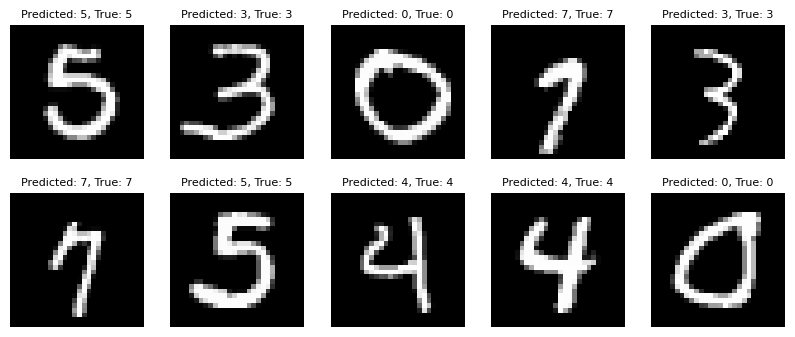

In [26]:
# Prepare the MNIST Dataset
train_fraction = 0.8
test_fraction = 1 - train_fraction

# Shuffle the dataset before splitting
indices = np.random.permutation(len(X_mnist))
X_mnist = X_mnist[indices]
y_mnist = y_mnist[indices]
train_size = int(train_fraction * len(X_mnist))
X_train_mnist, y_train_mnist = X_mnist[:train_size], y_mnist[:train_size]       
X_test_mnist, y_test_mnist = X_mnist[train_size:], y_mnist[train_size:]

def one_hot_encode(y, num_classes):
    return jax.nn.one_hot(y, num_classes)

input_dim = 784  # MNIST images are 28x28 pixels, flattened to 784
output_dim = 10  # 10 classes for digits 0-9


# YOUR PARAMETERS HERE
epochs = 1000
learning_rate = 0.1
N = 16
L = 3

# YOUR MODIFIED CLASSIFIER HERE
classifier_mnist = lambda x, params: jax.nn.softmax(MLP_jax(x, params))
vmapped_classifier = vmap(classifier_mnist, in_axes=(0, None))

# YOUR MULTICLASS LOSS FUNCTION HERE
def multiclass_cross_entropy_loss(x, y_true, params):
    y_pred = vmapped_classifier(x, params)
    epsilon = 1e-10  # Small value to avoid log(0)
    return -jnp.mean(jnp.sum(y_true * jnp.log(y_pred + epsilon), axis=1))

# YOUR TRAINING LOOP HERE
params_mnist = init_params_jax(input_dim, output_dim, L, N)
train_losses_mnist = []
test_losses_mnist = []  

@jit
def gradient_step_mnist(x, y_true, params, learning_rate=0.01):
    loss = multiclass_cross_entropy_loss(x, y_true, params)
    grads = grad(multiclass_cross_entropy_loss, argnums=2)(x, y_true, params)

    Ws, bs = params
    dWs, dbs = grads
    new_Ws = [W - learning_rate * dW for W, dW in zip(Ws, dWs)]
    new_bs = [b - learning_rate * db for b, db in zip(bs, dbs)]
    new_params = (new_Ws, new_bs)

    return new_params, loss



# Train the model
for epoch in range(epochs):
    params_mnist, loss = gradient_step_mnist(X_train_mnist, one_hot_encode(y_train_mnist, output_dim), params_mnist, learning_rate)
    train_losses_mnist.append(loss)
    test_loss = multiclass_cross_entropy_loss(X_test_mnist, one_hot_encode(y_test_mnist, output_dim), params_mnist)
    test_losses_mnist.append(test_loss)

    # compute the accuracy
    y_pred = jnp.argmax(vmap(classifier_mnist, in_axes=(0, None))(X_test_mnist, params_mnist), axis=1)
    accuracy = jnp.mean(y_pred == y_test_mnist)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")



# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses_mnist, label='Train Loss')
plt.plot(test_losses_mnist, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

# Plot some predictions
fig, ax = plt.subplots(2, 5, figsize=(10, 4))   
for i in range(10):
    ax[i // 5, i % 5].imshow(X_test_mnist[i].reshape(28, 28), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Predicted: {jnp.argmax(classifier_mnist(X_test_mnist[i], params_mnist))}, True: {y_test_mnist[i]}", fontsize=8)
    ax[i // 5, i % 5].axis('off')





###STOP_SOLUTION

## Chapter 2.3 (BONUS): Solving ODE's with MLPs and Autodiff

We'll explore how we can use MLPs to solve ODEs. The idea is to represent our solution $f(x)$ as an MLP, and write the ODE as the minimum of a loss function. We can use autodiff to compute the derivatives of $f(x)$, and then use gradient descent to minimize the loss function. Unlike what we did above, there is no training (this is not a statistical problem). Also, we are now dealing with gradients of the function within respect to the input AND with respect to the model parameters.

Suppose we have an ODE of the form $F(f, f', x) = 0$, where $f$ is the function we want to solve for, $f'$ is the derivative of $f$ with respect to $x$, and $F$ is some function that defines the ODE. We can define a loss function as:
$$ L[f] = \int dx |F(f, f', x)|^2 $$

where the integral is over the domain of $x$ we are interested in. The goal is to minimize this loss function with respect to the parameters of the MLP that defines $f(x)$.


HINT: If $f(x)$ is just an MLP, then your solution will likely just collapse to just $f(x) = 0$. Try to find a way to write $f(x) = $ something involving an MLP but also manifestly satisfies the initial condition.

BONUS: If you try to do a second-order ODE using our MLP, the solution will fail miserably. Why? Hint: this relates to piecewise-linearity. Can you fix this? 

Fill out the rest of this code to build our approximate ODE solver! This requires only minor modifications to the code we have already written above.

Epoch 0, Loss: 0.0000
Epoch 100, Loss: 0.0000
Epoch 200, Loss: 0.0000
Epoch 300, Loss: 0.0000
Epoch 400, Loss: 0.0000
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


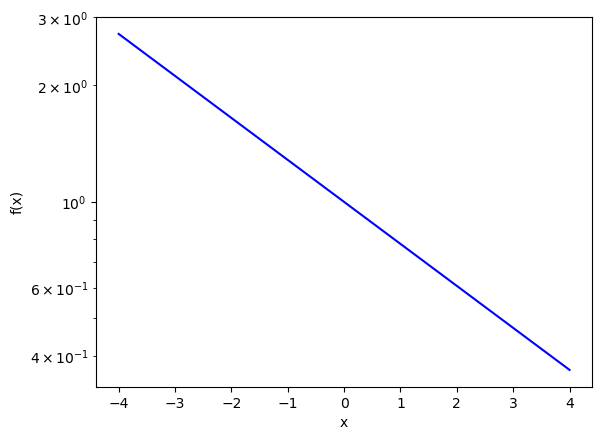

In [30]:
###START_EXERCISE
# We will only solve the ODE on a compact domain
x_domain = jnp.linspace(-4, 4, 1000)
x_domain = x_domain.reshape(-1, 1)  # Reshape to (1000, 1) for compatibility with MLP

x_0 = 0
f_0 = 1 # Initial condition: f(0) = 1


def F(f_x, grad_f_x, x):

    # Example ODE: f = exp(-0.25 * x)
    ODE_term =  0.25 * f_x + grad_f_x

    return ODE_term 


# HINT: If your solution f(x) is just an MLP, you will likely only find trivial solutions and fail to satisfy the initial condition.
# Try to arrange f(x) to always satisfy the initial condition and then learn the rest of the solution!
def my_solution(x, params):

    g_x = MLP_jax(x, params)  # Get the output of the MLP

    #  ... Rest of your solution
    return 0


vmapped_ODE_solution = vmap(my_solution, in_axes=(0, None))  # Vectorized solution function

# lambda function to make the output of my_solution a scalar so that we can compute the gradient
vmapped_grad_ODE = vmap(grad(lambda x, params: my_solution(x, params).squeeze(), argnums=0), in_axes=(0, None))  # Vectorized gradient of MLP

# [... REST OF YOUR SOLUTION]
def gradient_step_ODE(params, learning_rate=0.01):

    # YOUR SOLUTION HERE
    return params, 0

# Initialize the parameters for the ODE solver
input_dim = 1
output_dim = 1
L = 3
N = 17
params = init_params_jax(input_dim, output_dim, L, N)



# Train the ODE solver
epochs = 1000
for epoch in range(epochs):
    params, loss = gradient_step_ODE(params, learning_rate=0.01)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Plot the solution
y_vals = vmapped_ODE_solution(x_domain, params)
plt.plot(x_domain, jnp.exp(-0.25 * x_domain), label='True Solution: exp(-x)', color='blue')
plt.plot(x_domain, y_vals, label='MLP Solution', color='orange')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.yscale('log')

###STOP_EXERCISE


###START_SOLUTION

In [ ]:
# We will only solve the ODE on a compact domain
x_domain = jnp.linspace(-4, 4, 1000)
x_domain = x_domain.reshape(-1, 1)  # Reshape to (1000, 1) for compatibility with MLP

x_0 = 0
f_0 = 1 # Initial condition: f(0) = 1

def my_solution(x, params):

    g_x = MLP_jax(x, params)  # Get the output of the MLP

    # This solution will automatically satisfy the initial condition
    f_x = f_0 + (x - x_0) * g_x  

    return f_x


vmapped_ODE_solution = vmap(my_solution, in_axes=(0, None))  # Vectorized solution function

# lambda function to make the output of my_solution a scalar so that we can compute the gradient
vmapped_grad_ODE = vmap(grad(lambda x, params: my_solution(x, params).squeeze(), argnums=0), in_axes=(0, None))  # Vectorized gradient of MLP


def F(f_x, grad_f_x, x):

    # Example ODE: f = exp(-0.25 * x)
    ODE_term =  0.25 * f_x + grad_f_x

    return ODE_term 

vmapped_grad_MLP = vmap(grad(lambda x, params: MLP_jax(x, params).squeeze(), argnums=0), in_axes=(0, None))  # Vectorized gradient of MLP

def ODE_loss(params):

    # Compute the loss as the mean squared error between the network output and the ODE solution
    f_x = vmapped_ODE_solution(x_domain, params)  # params is a tuple of (Ws, bs)
    grad_f_x = vmapped_grad_ODE(x_domain, params)

    # Compute the ODE residual
    residual = F(f_x, grad_f_x, x_domain)

    # Mean squared error loss
    return jnp.mean(residual**2)

def gradient_step_ODE(params, learning_rate=0.01):

    # Compute the loss and its gradient
    loss = ODE_loss(params)
    grads = grad(ODE_loss)(params)

    # Update the network parameters using gradient descent
    Ws, bs = params
    dWs, dbs = grads
    new_Ws = [W - learning_rate * dW for W, dW in zip(Ws, dWs)]
    new_bs = [b - learning_rate * db for b, db in zip(bs, dbs)]
    new_params = (new_Ws, new_bs)

    return new_params, loss


# Initialize the parameters for the ODE solver
input_dim = 1
output_dim = 1
L = 3
N = 17
params = init_params_jax(input_dim, output_dim, L, N)



# Train the ODE solver
epochs = 1000
for epoch in range(epochs):
    params, loss = gradient_step_ODE(params, learning_rate=0.01)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Plot the solution
y_vals = vmapped_ODE_solution(x_domain, params)
plt.plot(x_domain, jnp.exp(-0.25 * x_domain), label='True Solution: exp(-x)', color='blue')
plt.plot(x_domain, y_vals, label='MLP Solution', color='orange')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.yscale('log')

###STOP_SOLUTION

## Chapter 2.4: Some notes on JAX Prebuilt Libraries

JAX has a number of prebuilt libraries that can be useful for machine learning. Some of the most popular ones are:
1. **Flax**: A neural network library for JAX that provides a high-level interface for building and training neural networks. It is similar to PyTorch in terms of functionality, but uses JAX's functional programming style.
2. **stax**: A library for probabilistic programming in JAX. It provides a high-level interface for building and training probabilistic models, and is similar to PyMC3 or TensorFlow Probability.

However, we will not cover these in any great depth This is because if you are going to use prebuilt libraries, you are probably better off using PyTorch or TensorFlow, which have more mature libraries and a larger community. JAX is more useful for experimentation with explicitly defined models and getting into the guts of it all.

Just for completeness, we will show how to use stax to build a simple MLP. This is not meant to be a comprehensive tutorial on these libraries, but rather a quick introduction to their usage so you can see the syntax. The syntax between stax and flax is virtually identical. Both are also directly meant to mimic PyTorch anyways, so after this example, we will go into an in-depth PyTorch tutorial.

stax loss: 0.026685454


Text(0, 0.5, 'x2')

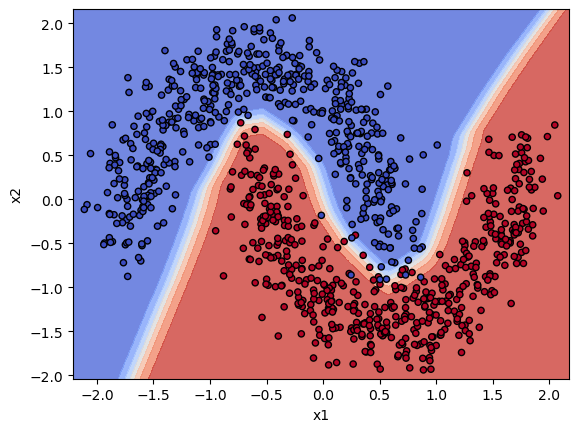

In [109]:

from jax.example_libraries import stax

# prepare data
indices = np.random.permutation(len(X_moons))
X_moons = X_moons[indices]
y_moons = y_moons[indices]
X_moons = X_moons.astype(np.float32)  # Convert to float32 for JAX compatibility
y_moons = y_moons.astype(np.float32)  # Convert to float32 for JAX compatibility    


# A model is a sequential list of layers
init, apply = stax.serial(
    stax.Dense(32), stax.Relu, # Dense(N) is a fully connected layer with output dimension N. The input dimension is inferred from the input data.
    stax.Dense(32), stax.Relu,
    stax.Dense(32), stax.Relu,
    stax.Dense(1)
)


# init is the function to initialize the parameters of the model.
# apply is the function to apply the model to the input data.

key = random.PRNGKey(0)
key1, key2 = random.split(key)
_, params = init(key2, (-1,2))

# Define a loss function for binary classification
def loss(params,x,y):
    logits = jnp.squeeze(apply(params,x))
    return -jnp.mean(y*jax.nn.log_sigmoid(logits)+(1-y)*jax.nn.log_sigmoid(-logits))

@jit # Same type of gradient step as before, but now using stax
def step(params,x,y,lr=0.01):
    grads = grad(loss)(params,x,y)

    # tree_map is a JAX function that applies a function to each leaf of a pytree (like a list of arrays)
    # Makes it easy to update the parameters all at once
    return jax.tree_util.tree_map(lambda a,b: a-lr*b, params, grads)

for _ in range(10000):
    params = step(params,X_moons,y_moons)

print("stax loss:", loss(params,X_moons,y_moons))

# Decision boundary
x_min, x_max = X_moons[:, 0].min() - 0.1, X_moons[:, 0].max() + 0.1
y_min, y_max = X_moons[:, 1].min() - 0.1, X_moons[:, 1].max() + 0.1
xx, yy = jnp.meshgrid(jnp.linspace(x_min, x_max, 100), jnp.linspace(y_min, y_max, 100))
xs = jnp.array(list(zip(xx.ravel(), yy.ravel())))
Z = jnp.squeeze(apply(params, xs))
Z = Z.reshape(xx.shape)
fig, ax = plt.subplots()
ax.contourf(xx, yy, jax.nn.sigmoid(Z), alpha=0.8, cmap='coolwarm')
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, edgecolors='k', marker='o', s=20, cmap='coolwarm')
plt.xlabel('x1')
plt.ylabel('x2')


# Chapter 3: PyTorch

PyTorch is a popular ML library developed by Meta (formerly Facebook). It is widely used in industry and research. It is typically more high-level than JAX, and has a wider range of prebuilt modules and utilities for common ML tasks. It is also older and more widely supported with documentation and tutorials online. 

Unlike JAX, PyTorch is object-oriented, meaning that we will define an MLP as a class with an internal state that keeps track of the parameters. 



In [6]:
import torch
import torch.nn as nn
device='cuda' if torch.cuda.is_available() else 'cpu'

## Chapter 3.1: Primer on PyTorch tensors and autodiff

PyTorch has its own tensor class, which are similar to (but not the same as) numpy arrays. They can live on a "device" (e.g. `cuda` or `cpu`), and can be used to perform computations on that device. PyTorch tensors have many of the same methods as numpy arrays, but also have some additional methods for ML tasks, such as `backward()` for computing gradients.

Autodiff in PyTorch is different than in JAX. In PyTorch, we define a computation graph by performing operations on tensors, and then call `backward()` on the output tensor to compute the gradients. This is different from JAX, where we define a function and then call `grad()` on that function to compute the gradients. Once a tensor is in the graph, it cannot be converted back to numpy without first `detach`ing it. 

To emphasize, in JAX, we take derivatives of functions, and the derivative of a function is another function. In PyTorch, we tell the graph to keep track of a tensor, we pass the tensor through a function, and then we ``backpropagate'' the resultant tensor. Derivatives are computed on the output tensor and the result is a tensor. 

Gradient at x=0.0:  10.0


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

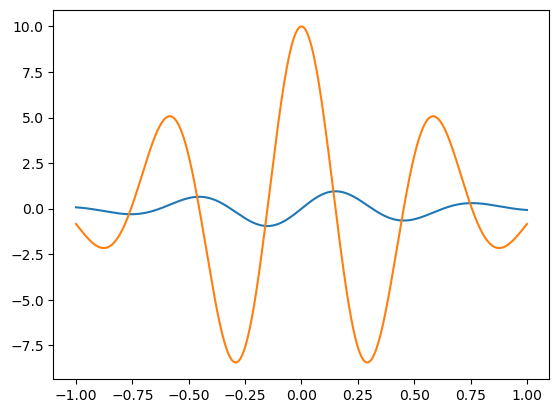

In [32]:

# A pytorch tensor defined from our numpy moons dataset
x_pytorch = torch.tensor(X_moons, dtype=torch.float32, device=device)

# Converting the pytorch tensor back to a numpy tensor 
x_numpy = x_pytorch.numpy()  


##### DEFINING GRADIENTS AND COMPUTATION GRAPHS ######

# Define a function and compute gradients
def f_torch(x):
    return torch.sin(10*x) * torch.exp(-2*x**2)


# requires_grad=True to compute gradients later! Try setting to False and see what happens!

x_single = torch.tensor([0.0], device=device, requires_grad=True)  # Single value tensor
y_single = f_torch(x_single)  # Compute the function value




# We want to compute the gradient of the function and plot it.
# First, we call .backward on the output of the function (not the function itself!).
# This tells Pytorch its time to compute the gradients in the computational graph.

y_single.backward()  # Compute the gradient for the single value

# Now the gradients are computed. To access it, we use .grad() on the input tensor.
print("Gradient at x=0.0: ", x_single.grad.item())  # Should print the gradient at x=0.0



##### MULTIPLE INPUTS ######

# The same as above, but now on a vectorized input
xs = torch.linspace(-1, 1, 1000, device=device, requires_grad=True)  
ys = f_torch(xs)

# We cannot just use ys.backward() because ys is a vector, not a scalar.
# ys has 1000 elements, and xs has 1000 elements, so PyTorch thinks there is a 1000 x 1000 jacobian!
# We need to specify a gradient direction to sum the gradients over the output dimension. Since y_j is indepndent of x_i for i!=j, we can just use a vector of ones as the gradient direction.
gradient_direction = torch.ones_like(ys, device=device)  # 
_ = ys.backward(gradient=gradient_direction)  # Compute the gradients
# Now we can access the gradients
xs_grad = xs.grad  # This will be a tensor of the same shape as xs in the specified direction.


# Plot the function and its gradient
plt.plot(xs.detach().numpy(), ys.detach().numpy(), label='f(x)')
plt.plot(xs.detach().numpy(), xs_grad, label='f\'(x)')


# Zero-ing out gradients
# In PyTorch, gradients accumulate by default, so we need to zero them out before the next backward pass.
x_single.grad.zero_()  # Zero out the gradients
xs.grad.zero_()  # Zero out the gradients


## Chapter 3.2: Pre-built PyTorch Modules

The `Sequential` class

There are many possible layers of abstraction in PyTorch. The highlest-level, "I don't care, I just want a neural network, don't bother me with details" way to define an MLP is to use the `Sequential` class. 

Most models are simply a sequence of layers, where each layer is a function that takes in the output of the previous layer and produces an output. The `Sequential` class allows us to define a model as a sequence of layers, where each layer is applied in order. The ``nn` module provides many prebuilt layers, such as `Linear`, `ReLU`, and `Softmax`, that can be used to define a model. Note that `Linear` actually means "Affine", i.e. it implements the affine transformation $W x + b$.

Let's see how to implement an MLP. Compared to the above implementations, this will be much shorter and cleaner, since most of this is already implemented for us in PyTorch (but the cost is that we have less control over the details of the implementation, like if we wanted to mess with layer weights). Note that we don't even have to worry about the initialization of the weights, since PyTorch does this for us automatically.

We also don't have to bother defining a loss function or gradient descent, sice this also already exists.

In [33]:
input_dim = 2
output_dim = 1


model = nn.Sequential(
    nn.Linear(input_dim,32), nn.ReLU(),
    nn.Linear(32,32), nn.ReLU(), # We just stack a bunch of layers
    nn.Linear(32,output_dim)  # No activation on the last layer. Instead, we'll put the sigmoid or softmax in the loss function..
).to(device) # .to(device) moves the model to the GPU if available


# Lots of optimizers to choose from! SGD is ordinary (stochastic) gradient descent, Adam is a more advanced optimizer.
opt_sgd = torch.optim.SGD(model.parameters(), lr=1e-2) 
opt_adam = torch.optim.Adam(model.parameters(), lr=1e-2)


# Prebuilt BCE. Already includes the sigmoid, so we don't need to apply it in the model.
loss_fn = nn.BCEWithLogitsLoss()




In [ ]:
# Train the model
epochs = 300
train_fraction = 0.8
opt = opt_adam  # Choose the optimizer

X_torch = torch.tensor(X_moons, dtype=torch.float32, device=device)
y_torch = torch.tensor(y_moons, dtype=torch.float32, device=device).unsqueeze(1)  # Unsqueeze to make it a column vector

# Training/test split, shuffle the dataset
train_size = int(train_fraction * len(X_torch))
indices = torch.randperm(len(X_torch))  # Shuffle the dataset
X_torch = X_torch[indices]
y_torch = y_torch[indices] 
X_train, y_train = X_torch[:train_size], y_torch[:train_size]
X_test, y_test = X_torch[train_size:], y_torch[train_size:]


train_losses = []
test_losses = []

for _ in range(300):


    opt.zero_grad() # Zero out the gradients before the backward pass. VITAL!
    loss = loss_fn(model(X_train), y_train)
    loss.backward() # Tell the graph its time to compute the gradients
    opt.step() # "step" automatically updates the parameters using the gradients computed in the backward pass
    train_losses.append(loss.item())  # Save the training loss
    test_loss = loss_fn(model(X_test), y_test)
    test_losses.append(test_loss.item())  # Save the test loss
    if _ % 10 == 0:
        print(f"Epoch {_}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

print("PyTorch loss:", loss.item())

In [ ]:
# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()

# Plot the decision boundary
fig, ax = plt.subplots()
x_min, x_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1   
y_min, y_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1
xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100), torch.linspace(y_min, y_max, 100))
xs = torch.stack([xx.ravel(), yy.ravel()], dim=1).to(device)  # Stack to create a grid of points
Z = model(xs)  # Get the model predictions


# Dont forget to apply the sigmoid to the logits!
Z = torch.sigmoid(Z)  # Apply sigmoid to the logits

Z = Z.detach().cpu().numpy()
Z = Z.reshape(xx.shape)  # Reshape to match the grid shape
ax.contourf(xx.cpu().numpy(), yy.cpu().numpy(), Z, alpha=0.8, cmap='coolwarm')
ax.scatter(X_test[:, 0].cpu().numpy(), X_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), edgecolors='k', marker='o', s=20, cmap='coolwarm')
plt.show()

### Exercise 3.1:



Now that we don't have to code anything, lets try some more advanced things.
1) Compare the ADAM optimizer to the SGD optimizer. 
2) Trade out the ReLU activation for sigmoid (used in the original MLP's back in the day), selu (a variant of ReLU that doesn't go to 0), and others. How do they compare? The modern lore in 2025 is to use "Swish" (aka "SiLU") activations, which are supposedly better than ReLU. There are many more at https://docs.pytorch.org/docs/main/nn.functional.html#non-linear-activation-functions. Try them out!
3) PyTorch MLP layers are called "Linear" despite being affine transformations. Let's see what happens if they are literally linear: the bias term can be removed with `bias=False`, e.g. `nn.Linear(32,32, bias = False)`. What happens to the decision boundary? As you do this, reflect on the exercise we did earlier where we constructed MLPs to exactly match piecewise linear functions, and the role the bias played there.
4) It should be straightforward to change the model to work on MNIST.


In [1]:
###START_EXERCISE
# your solution goes here
###STOP_EXERCISE

In [2]:
###START_SOLUTION
# 
###STOP_EXERCISE

## Chapter 3.3: Convolutional Neural Networks (CNNs)

MLP's are already universal function approximators. But we can do better!

Often, and especially in physics, our function has some structure we can exploit (such as symmetries, or locality). Perhaps we can use this symmetry to constrain the weights of the MLP, or even better (and equivalently), design a new MLP-like-model that has this symmetry built in and is a universal function approximator with respect to this symmetry.

Image classification has an approximate translational symmetry: If an image of a handwritten "5" is shifted to the right, it is still a "5". We can exploit this symmetry by using a **Convolutional Neural Network (CNN)**, which is a type of neural network that is specifically designed for image classification tasks that has this translational symmetry built in. A CNN can achieve significantly better performance than an MLP with the same number or far fewer parameters.

A 2D translation on our 784-dimensional input space is a violent operation, and a generic MLP will not be translationlly invariant (or covariant). One can attempt to solve for a special class of $W$'s that are covariant (related to Toeplitz matrices), but this will end up being related to convolutions anyways. 

Instead, if we represent an image as a distribution $I(x)$, where $I(x)$ is the pixel value at position $x$ (and there can be multiple channels, e.g. RGB labelled by $I^a(x)$), then the following operation (**convolution**) is equivalent to a translation-invariant operation:
$$ (I * K)^b(x) = \int dy \sum_a I^a(y) K^b(x - y) $$
where $K^b(x)$ is a kernel (or filter) that is applied to the image (there can be several kernels, labeled by $b$ and summed over $a$). The convolution operation is equivalent to sliding the kernel over the image and computing the dot product at each position.

Then, we can construct a universal function approximator for translation-invariant functions:
$$F(I) = \Psi(\int dx [\text{Equivariant operations on I}])$$

where $\Psi$ is any function that is a universal function approximator (e.g. an MLP). This is the basic recipe for a CNN. We use (discrete) convolutions to extract features from an image in an equivariant way aggregate them (represented by the integral, but it could also any other invariant aggregation like max-pooling), then feed them into an MLP. In practice, we will interleave pooling with the convolutions (since it also helps introduce nonlinearity) and use max-pooling rather than integration (mean-pooling) for more nonlinearity.

Images are not exactly translation invariant, but they are approximately so. In particular, they are discrete, and they have boundaries. So we will use a discrete convolution, and use pading on boundaries. We will also assume that our convolutions are local (the support of $K(x-y)$ is dominated by $x \sim y$), so that we can write our kernels as small $3\times 3$ or ($5\times 5$) matrices. 


We will also make use of the ``nn.Module`` class. This is the base class for all neural network modules in PyTorch. It is one level of abstraction above the ``nn.Sequential`` class, and allows us to define the model with more contrl (e.g. we can define the parameters of the model directory (the layers in most models), and we can define how those paramrameters are used to define the function (the ``forward`` method).)

We will also see our first example of a nontrivial layer beyond just the linear layer. The `nn.Conv2d` layer is a convolutional layer that applies a 2D convolution to the input. It takes as input the number of input channels, the number of output channels, and the kernel size (the size of the filter). It also has a stride and padding parameter, which control how the convolution is applied to the input.

In [8]:
# Constructing a PyTorch CNN

class SimpleCNN(nn.Module):

    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Input channels = 1 for grayscale images
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 16)  # Assuming input images are 28x28, and we aggregate down to 7x7.
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2) #aggregation: Take every 2x2 block and take the maximum value
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2) #After 2 aggregations, we go from 28x28 to 14x14 to 7x7.

        # We havent aggregated all the way down to a single value, so we arent perfectly invariant to translation.
        # But we are invariant to small translations, which is good enough!

        x = x.view(x.size(0), -1)  # Flatten the tensor: 

        # MLP part:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# Initialize the CNN model
model_cnn = SimpleCNN(num_classes=10).to(device)  # Move the model to the GPU if available

# Define the optimizer and loss function (IDENTICAL TO BEFORE)
opt_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-2)  # Adam optimizer
loss_fn_cnn = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Data. We can treat the images as genuine 28x28x1 (1 = no color) images, rather than flattening them to 784.
train_fraction = 0.8
train_size = int(train_fraction * len(X_mnist)) // 5 # Use a smaller training set for faster training, just for tutorial's sake
indices = torch.randperm(len(X_mnist))  # Shuffle the dataset
X_mnist_torch = torch.tensor(X_mnist, dtype=torch.float32, device=device).unsqueeze(1).reshape(-1, 1, 28, 28)  # Reshape to (N, C, H, W)
y_mnist_torch = torch.tensor(y_mnist, dtype=torch.long, device=device)  # Long tensor for class labels
X_train_mnist_torch, y_train_mnist_torch = X_mnist_torch[indices[:train_size]], y_mnist_torch[indices[:train_size]]
X_test_mnist_torch, y_test_mnist_torch = X_mnist_torch[indices[train_size:]], y_mnist_torch[indices[train_size:]]


# Train the CNN model
epochs = 100  # Far fewer epochs needed!
train_losses_cnn = []
test_losses_cnn = []    

for epoch in range(epochs):
    opt_cnn.zero_grad()  # Zero out the gradients before the backward pass
    outputs = model_cnn(X_train_mnist_torch)  # Forward pass
    loss = loss_fn_cnn(outputs, y_train_mnist_torch)  # Compute the loss
    loss.backward()  # Backward pass to compute gradients
    opt_cnn.step()  # Update the model parameters
    train_losses_cnn.append(loss.item())  # Save the training loss

    # Evaluate on the test set
    with torch.no_grad():  # No need to compute gradients for evaluation
        test_outputs = model_cnn(X_test_mnist_torch)
        test_loss = loss_fn_cnn(test_outputs, y_test_mnist_torch)
        test_losses_cnn.append(test_loss.item())  # Save the test loss

        # Compute accuracy
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == y_test_mnist_torch).float().mean().item()

    if epoch % 1 == 0:  # Print every epoch
        print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}")

# Plot the training and test losses
fig, ax = plt.subplots()
plt.plot(train_losses_cnn, label='Train Loss')  
plt.plot(test_losses_cnn, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()


Epoch 0, Train Loss: 2.3214, Test Loss: 2.2814, Accuracy: 0.1026
Epoch 1, Train Loss: 2.2810, Test Loss: 2.2259, Accuracy: 0.1685
Epoch 2, Train Loss: 2.2242, Test Loss: 2.1169, Accuracy: 0.2274
Epoch 3, Train Loss: 2.1150, Test Loss: 1.9444, Accuracy: 0.4804
Epoch 4, Train Loss: 1.9434, Test Loss: 1.7457, Accuracy: 0.5478
Epoch 5, Train Loss: 1.7450, Test Loss: 1.5515, Accuracy: 0.5394
Epoch 6, Train Loss: 1.5508, Test Loss: 1.4259, Accuracy: 0.5366
Epoch 7, Train Loss: 1.4328, Test Loss: 1.3382, Accuracy: 0.5533
Epoch 8, Train Loss: 1.3454, Test Loss: 1.1572, Accuracy: 0.6188
Epoch 9, Train Loss: 1.1657, Test Loss: 1.0832, Accuracy: 0.6475
Epoch 10, Train Loss: 1.0902, Test Loss: 1.0160, Accuracy: 0.6730
Epoch 11, Train Loss: 1.0215, Test Loss: 0.9594, Accuracy: 0.6757
Epoch 12, Train Loss: 0.9674, Test Loss: 0.8428, Accuracy: 0.7332
Epoch 13, Train Loss: 0.8401, Test Loss: 0.8087, Accuracy: 0.7308
Epoch 14, Train Loss: 0.8062, Test Loss: 0.7367, Accuracy: 0.7541
Epoch 15, Train Loss

KeyboardInterrupt: 

## Chapter 3.4 (BONUS): Permutation Invariance and Equivariance with Deep Sets and Transformers

We saw above how we can use convolutions to exploit translational symmetry. In this section, we will see how we can exploit permutation symmetry of inputs. Here, we are interested in functions of SETS to real numbers, rather than functions of vectors to real numbers. Sets are invariant to the order of the elements, meaning that the function should produce the same output regardless of the order of the points in the set. One immediate upside of this is that our model can allow for an arbitrary input size, since it's still a set regardless of how many points are in it!

In physics, we often deal with sets of particles or measurements, where the particle labeling is completely arbitrary, so this symmetry is important. We also often do not have a fixed number of particles, so we want our model to be able to handle an arbitrary number of particles.

Two models that are designed to exploit permutation symmetry are **Deep Sets** and **Transformers**. 

A Deep Set is a type of network that is a universal function approximator for functions of sets. It is defined as:
$$ f(S) = \Psi\left(\sum_{x \in S} \phi(x)\right) $$
where $\phi$ is a function that maps each element of the set to a vector, and $\Psi$ is a function that aggregates the vectors into a single vector. Both are MLPs! It is manifestly invariant to the order of the points in the set. Note that even though $\phi$ only acts on a single element at a time, inter-point correlations are still captured by the aggregation function $\Psi$ (though not necessarily efficiently). 

Transformers are a more general class of networks that include Deep Sets as a special case. Transformers are extremely common and have exploded in popularity in the last few years, especially in the context of natural language processing (NLP). Most of the most powerful models in high energy physics (such as Particle Transformer), as well as models outside physics (such as ChatGPT) are Transformers. 

Transformers are based on permutation equivariant layers:
$$ f(x_i) = \sigma(C_{ij}x_j + \phi(x_i, x_j)D_{jk}x_k)$$
where $C$ and $D$ are matrices that are shared across all points in the set, and $\phi$ is some symmetric kernel. This is the simplest non-linear layer one can construct that is permutation invariant. Typically, $\phi = \text{softmax}(\langle Qx_i, K x_j\rangle)$. 


A lot of literature about transformers is based on natural language processing, so it's worth getting used to. Just for terminology's sake, it is common to call $Q_i$ the "query vector", $K_j$ the "key vector", and $V_j = D_{jk} x_k$ the "value vector", but these are just names and don't have any special meaning outside the very specific context of NLP. Emotionally, $Q$ is supposed to represent the "question" we are asking about the input $x_i$, $K$ is supposed to represent the "context" of the input $x_j$, and $V$ is supposed to represent the "value" of the input $x_k$. This  construction is called the **self-attention** layer, because the kernal $\phi$ is a function from 0 to 1 that tells the model at $x_i$ how much to "pay attention" to $x_j$, but these are just non-rigorous words invented before the math was understood and don't get too caught up in them. The elements of the sets are called "tokens", because words are often encoded as tokens. Note that since self-attention is permutation invariant, the order of words in a sentence is usually encoded into the token itself to break the symmetry, or the kernel is forced to be 0 if the words are out of order.

Both the deep-sets and the transformer were written as a scalar output. One can easily extend this to a vector of outputs by appropriately appending extra indcies to everything.

### TOY MODEL:

We will construct the following problem: Every point is a list of 10 random vectors. If the sum of all pairwise dot-products of the vectors in the set is positive, then the output is 1, otherwise it is 0. E.g. we are testing if the set of vectors are roughly pointing in the same direction or not. This problem is permnutation invariant (so Deep Sets or Transformers will be useful), but explicitly involves pairwise nonlinear correlations (so a small Deep Sets will struggle).


MLP
epoch 00  train-loss 0.6928  test-loss 0.7078  acc 0.533
epoch 05  train-loss 0.6778  test-loss 0.6872  acc 0.541
epoch 10  train-loss 0.6303  test-loss 0.6686  acc 0.590
epoch 15  train-loss 0.5065  test-loss 0.5971  acc 0.676
epoch 20  train-loss 0.3566  test-loss 0.6194  acc 0.705
epoch 25  train-loss 0.2617  test-loss 0.5933  acc 0.732
epoch 30  train-loss 0.1977  test-loss 0.5772  acc 0.752
epoch 35  train-loss 0.1474  test-loss 0.5868  acc 0.759
epoch 40  train-loss 0.0998  test-loss 0.6283  acc 0.763
epoch 45  train-loss 0.0698  test-loss 0.6859  acc 0.766
epoch 50  train-loss 0.0471  test-loss 0.7528  acc 0.765
epoch 55  train-loss 0.0301  test-loss 0.8277  acc 0.765

DeepSets
epoch 00  train-loss 0.6960  test-loss 0.7226  acc 0.533
epoch 05  train-loss 0.6910  test-loss 0.6910  acc 0.533
epoch 10  train-loss 0.6905  test-loss 0.6910  acc 0.533
epoch 15  train-loss 0.6904  test-loss 0.6910  acc 0.533
epoch 20  train-loss 0.6901  test-loss 0.6908  acc 0.533
epoch 25  train-

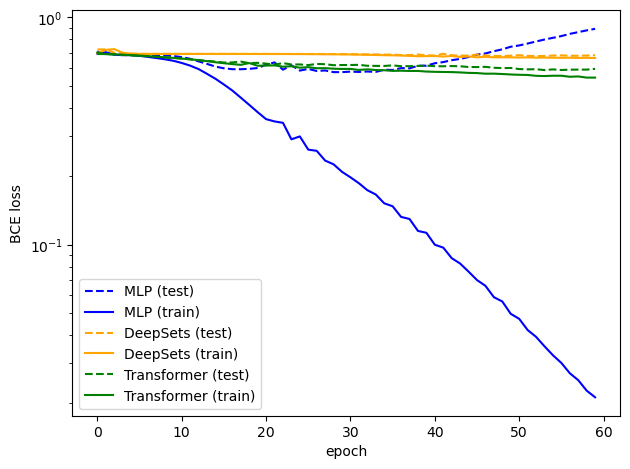

In [81]:
NUM_SAMPLES   = 25000          
SET_SIZE      = 10              # number of vectors in each set
FEATURES      = 16              # dimension of vectors

# Generate random sets
X_full = torch.randn(NUM_SAMPLES, SET_SIZE, FEATURES, device=device)

# Label is 1 if the sum of all pairwise dot products is positive

def upper_triangle_dot_sum(x_set):               # x_set: (n, d)
    total = 0.0
    for i in range(SET_SIZE):
        for j in range(i + 1, SET_SIZE):
            total += (x_set[i] * x_set[j]).sum() # simple dot­-product
    return total

y_full = torch.tensor(
    [upper_triangle_dot_sum(x) > 0 for x in X_full],
    dtype=torch.float32,
    device=device
).unsqueeze(1)                                   # shape (N, 1)

# Train / test split
train_size = 20000
X_train, y_train = X_full[:train_size], y_full[:train_size]
X_test,  y_test  = X_full[train_size:],  y_full[train_size:]


# ##### DEFINE MODELS #####


class MLP_torch(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),                        # (B, n*d)
            nn.Linear(SET_SIZE * FEATURES, 64), nn.ReLU(),
            nn.Linear(64, 64),                  nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)


class DeepSets(nn.Module):

    def __init__(self):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(FEATURES, 64), nn.ReLU(),
            nn.Linear(64, 64),       nn.ReLU(),
            nn.Linear(64, 64),       nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):                       # x: (B, n, d)
        h = self.phi(x)                         # (B, n, 64)
        s = h.sum(dim=1)                        # permutation-invariant
        return self.rho(s)


class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=FEATURES,
            nhead=4,
            dim_feedforward=64,
            batch_first=True
        )


        # Encoder layer: contains a stack of self-attention and feedforward layers as defined above
        # Can code this yourself if you really want, but PyTorch has a built-in implementation
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.head    = nn.Sequential(
            nn.Linear(FEATURES, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        h = self.encoder(x)                     # equivariant map
        g = h.mean(dim=1)                       # invariant aggregation
        return self.head(g)


models = {
    "MLP"        : MLP_torch().to(device),
    "DeepSets"   : DeepSets().to(device),
    "Transformer": Transformer().to(device)
}

# ##### TRAINING #####

def train_model(model, X_tr, y_tr, X_te, y_te,
                epochs=60, lr=1e-2, print_every=5):

    optimiser      = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses   = []
    test_losses    = []
    bce_loss       = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):

        # forward / backward on the entire training set 
        model.train()
        optimiser.zero_grad()
        logits      = model(X_tr)
        loss        = bce_loss(logits, y_tr)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_logits = model(X_te)
            test_loss   = bce_loss(test_logits, y_te)
            test_losses.append(test_loss.item())

            preds       = (torch.sigmoid(test_logits) > 0.5).float()
            accuracy    = (preds == y_te).float().mean().item()
        

        if epoch % print_every == 0:
            print(f"epoch {epoch:02d}  "
                  f"train-loss {loss.item():.4f}  "
                  f"test-loss {test_loss.item():.4f}  "
                  f"acc {accuracy:.3f}")

    return train_losses, test_losses


# ##### RESULTS #####
plt.figure()

colors = { "MLP": "blue", "DeepSets": "orange", "Transformer": "green" }
for name, net in models.items():
    print(f"\n{name}")
    tr_loss, te_loss = train_model(net,
                                   X_train, y_train,
                                   X_test,  y_test,
                                   epochs=60)
    plt.plot(te_loss, label=f"{name} (test)", ls ='--', color=colors[name])
    plt.plot(tr_loss, label=f"{name} (train)", color=colors[name])

plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("BCE loss")
plt.legend()
plt.tight_layout()
plt.show()


### Exercise: Linear Permutation Invariance

Can you design a problem for which DeepSets will outperform a transformer? That is, a problem for which inter-particle correlations are expected to be less important, so that the problem can be more easily written as a sum of single-particle functions?



In [3]:
###START_EXERCISE
# your solution goes here
###STOP_EXERCISE

In [ ]:
###START_SOLUTION
# your solution goes here
###STOP_SOLUTION

# Chapter 4: Tensorflow

Tensorflow (and the associated API, Keras) is another popular ML library developed by Google. It is similar to PyTorch in many ways. It used to be the most popular ML library years ago before being overtaken by PyTorch, but it is still widely used in industry and research. It is typically more high-level than JAX, and has a wider range of prebuilt modules and utilities for common ML tasks. It is also older and more widely supported with documentation and tutorials online.

Keras is a high-level API for Tensorflow that allows us to define models in an intuitive way. It is similar to the `nn.Sequential` class in PyTorch, but with more features and flexibility. Keras allows us to define models as a sequence of layers, where each layer is applied in order. It also has a wide range of prebuilt layers and utilities for common ML tasks.

We will not go into detail about Tensorflow and Keras, since they are similar to PyTorch and JAX, but we will provide a brief example of how to define an MLP in Keras, so that you are familiar with the syntax and can use it if you prefer.

Tensorflow has even more pre-built modules that are abstracted away from the user than PyTorch, so it is even easier to define models. You do not even have to write your own traning loop. One difference is that Tensorflow uses a "static graph" approach, meaning that the computation graph is defined before the model is run. The model must be specified and then "compiled", not entirely unlike JAX's JIT compilation. This means that the model is optimized for performance before it is run, which can lead to better performance in some cases. However, it also means that the model is less flexible and harder to debug, since you cannot change the model on the fly like you can in PyTorch or JAX.

A historical note: Tensorflow 1.0 is extremely different from Tensorflow 2.0 and Keras. We will only be using Tensorflow 2.0 and Keras, which is much more user-friendly and similar to PyTorch. It is rare to see Tensorflow 1.0 code these days, especially in physics, but it is worth being aware that it exists if you find yourself being confused by some old code.

## Chapter 4.1: Defining an MLP and a CNN in Keras

final val-acc: 0.9902439117431641


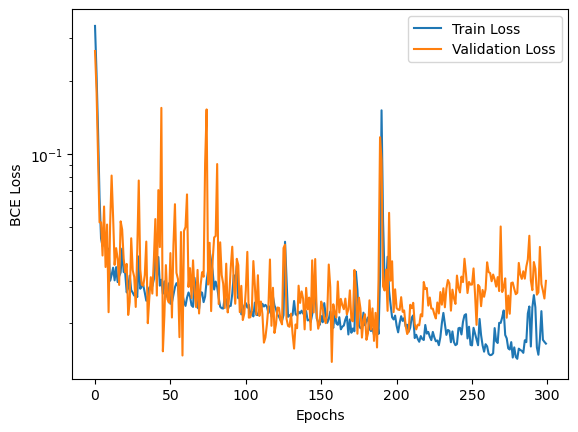

In [87]:
import tensorflow as tf
tf.random.set_seed(0)


# Something nice about tensorflow: You only have to specify the output dimension of a layer. The input is inferred.
mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)                 # logits
])

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'] # We can tell tensorflow what metrics we want to track on top of the loss!
)



# Tensorflow automatically has a training loop. We dont even need to split the dataset!
history = mlp.fit(X_moons, y_moons,
                  epochs=300, verbose=0,
                  validation_split=0.2)

# Training gives us a history object with the training and validation losses and accuracies. 
# Very convenient!

# Plot the training and validation losses
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()

print("final val-acc:", history.history['val_accuracy'][-1])


CNNS and Callbacks

A very cute feature of Keras/TF are "Callbacks", which are functions you can execute during the training loop. In JAX or PyTorch, you manually write training loops anyways and so can decorate them however you like, but Keras has a specialized interface for this. 

For example, you can define a callback that prints the training loss every 10 epochs, or a callback that saves the model every 100 epochs. This is very useful for debugging and monitoring the training process.

The most useful callback is the `EarlyStopping` callback, which stops the training process if the validation loss does not improve for a certain number of epochs. This is useful to prevent overfitting and save time during training. This can also be done for PyTorch and JAX, of course, but we are introducing it here since it is especially convenient. 

Many callbacks are built-in, but for the sake of this tutorial, we will also define a custom callback to print the mean and spread of the weights of each layer. This is useful to monitor the training process and see if the weights are exploding or vanishing.



Epoch 1/50
196/197 [============================>.] - ETA: 0s - loss: 2.2620 - accuracy: 0.1444Layer conv2d_8 - Mean: -0.0231, Std: 0.2600
Layer conv2d_9 - Mean: 0.0069, Std: 0.1167
Layer dense_14 - Mean: 0.0025, Std: 0.0670
Layer dense_15 - Mean: -0.0330, Std: 0.3280
197/197 [==============================] - 4s 20ms/step - loss: 2.2611 - accuracy: 0.1446 - val_loss: 2.0357 - val_accuracy: 0.2045
Epoch 2/50
195/197 [============================>.] - ETA: 0s - loss: 1.4010 - accuracy: 0.5337Layer conv2d_8 - Mean: -0.0448, Std: 0.4552
Layer conv2d_9 - Mean: 0.0163, Std: 0.1810
Layer dense_14 - Mean: 0.0092, Std: 0.1135
Layer dense_15 - Mean: -0.0403, Std: 0.4287
197/197 [==============================] - 4s 19ms/step - loss: 1.3952 - accuracy: 0.5361 - val_loss: 0.8552 - val_accuracy: 0.7554
Epoch 3/50
197/197 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7878Layer conv2d_8 - Mean: -0.0557, Std: 0.5334
Layer conv2d_9 - Mean: 0.0186, Std: 0.2074
Layer dense_14 -

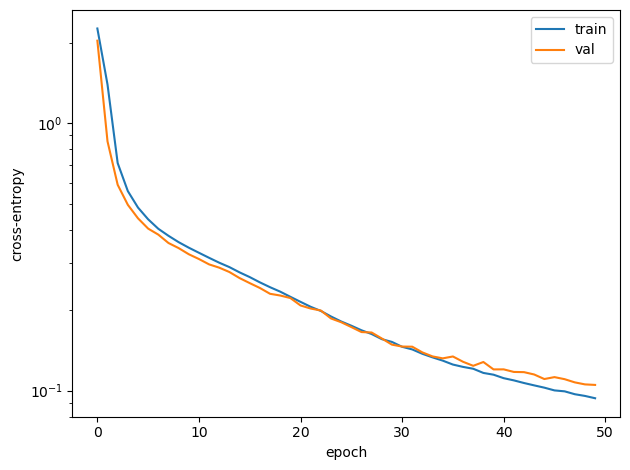

In [89]:
# Prepare data
X_mnist_np = X_mnist.astype("float32").reshape(-1, 28, 28, 1) / 255.0
y_mnist_np = y_mnist.astype("int32")                         # integer labels (0‒9)

idx        = np.random.permutation(len(X_mnist_np))
train_size = int(0.8 * len(idx))

X_train = X_mnist_np[idx[:train_size]]
y_train = y_mnist_np[idx[:train_size]]
X_test  = X_mnist_np[idx[train_size:]]
y_test  = y_mnist_np[idx[train_size:]]

# Basic CNN model in Keras. Basicly the same as in PyTorch! Slightly more convient since no input dimensions.
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10)                         # logits
])


cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),        
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# ########## CALLBACKS ##########

# Pre-built callback: Stop training if the validation loss does not improve for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Define a custom callback 
class LayerWeights(tf.keras.callbacks.Callback):
    
    # Override the on_epoch_end method so the function executed at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):

        # For each layer, print the mean and standard deviation of the weights
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                weights = layer.kernel.numpy()
                print(f"Layer {layer.name} - Mean: {np.mean(weights):.4f}, Std: {np.std(weights):.4f}")

hist = cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop, LayerWeights()],
    verbose=1
)

# ##### RESULTS #####
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=0)
print(f"MNIST  test-accuracy = {test_acc:.3f}")

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.yscale('log')
plt.xlabel('epoch'); plt.ylabel('cross-entropy')
plt.legend()


## Chapter 4.2: Custom Training Loops and GradientTape

Gradients in TF/Keras are a little unusual. Most operations in TF/Keras do not record gradients, unlike in JAX or PyTorch. Instead, you have to explicitly tell TF/Keras that it's time to record gradients using the `tf.GradientTape` context manager. Inside a GradientTape, all operations will record gradients, and you can then call `tape.gradient()` to compute the gradients of the output with respect to the inputs. This is not terribly dissimilar to PyTorch's `backward()` method, but it is more explicit and requires you to manage the context yourself.



In [91]:
# Setting up a toy problem to show off the manual training loop in TensorFlow

# Toy data: 1 000 points, y = 1 if x₁ + x₂ > 0 else 0
x_np = np.random.randn(1_000, 2).astype("float32")
y_np = ((x_np[:, 0] + x_np[:, 1]) > 0).astype("int32")
train_ds = (tf.data.Dataset                # batches of 128
            .from_tensor_slices((x_np, y_np))
            .shuffle(1_000)
            .batch(128))

# Toy MLP
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation="relu", input_shape=(2,)),
    tf.keras.layers.Dense(1)                                 # logits
])

opt  = tf.keras.optimizers.Adam(1e-3)
bce  = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# ##### MANUAL TRAINING LOOP #####

# This is more similar to the Pytorch and Jax Training Loops!
for epoch in range(10):
    running = 0.0
    for xb, yb in train_ds:

        # Open a "Gradient Tape" to tell Tensorflow its time to start recording the gradients of the following operations
        with tf.GradientTape() as tape:
            logits = model(xb, training=True)
            loss   = bce(yb, logits)

        # Use the gradients
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))

        running += loss.numpy()
        
    print(f"epoch {epoch:02d}  mean-loss {running / len(train_ds):.4f}")

epoch 00  mean-loss 0.6301
epoch 01  mean-loss 0.6189
epoch 02  mean-loss 0.6080
epoch 03  mean-loss 0.5979
epoch 04  mean-loss 0.5870
epoch 05  mean-loss 0.5765
epoch 06  mean-loss 0.5659
epoch 07  mean-loss 0.5560
epoch 08  mean-loss 0.5453
epoch 09  mean-loss 0.5348


### Exercise: Regularization

One way to prevent overfitting is to add a regularization term to the loss function. This can be done by adding a term that penalizes large weights, such as L1 or L2 regularization. 

There are two ways to do this in Keras:
1. Add a regularization term to the loss function manually, e.g. `loss = loss + lambda * tf.reduce_sum(tf.square(model.trainable_weights))`, where `lambda` is the regularization strength. Do this in the custom training loop.
2. Use a built-in regularization layer, such as `tf.keras.regularizers.l1` or `tf.keras.regularizers.l2`, and add it to the model when defining the layers, e.g. `tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.01))`. This can be done without needing a custom loop.

Method 2 is easier, but method 1 lets you control the form of the regularization directly. 
Try both methods and see how they affect the training process. Note how the spread of the weights (as recorded by our callback!) changes as a result of the regularization. 

A second type of regularization is **dropout**, which randomly sets a fraction of the inputs to zero during training. This can be done by adding a `tf.keras.layers.Dropout` layer to the model, e.g. `tf.keras.layers.Dropout(0.5)`. This is a very common regularization technique in deep learning, and can be used in conjunction with L1 or L2 regularization. It also has some nice interpretations in terms of Bayesian inference, but we will not go into that here. 

Try overfitting the model, but then adding dropout and/or L1/L2 regularization. 

In [4]:
###START_EXERCISE
# your solution goes here
###STOP_EXERCISE

In [ ]:
###START_SOLUTION
# your solution goes here
###STOP_SOLUTION

## CHAPTER 4.3 (BONUS): GANS and Generative Models

We will explore the simplest model of generative models, the **Generative Adversarial Network (GAN)**. In a previous tutorial, you learned about Normalizing Flows, which are a more sophisticated type of generative model that can learn complex distributions. GANs are a simpler type of generative model that can be used to generate new data that is similar to the training data. GANs make for a nice tutorial because they involve the interplay of *two* neural networks in a fun way, and show how MLPs can be combined to create new types of functions.

The basic premise is that we have two neural networks: a **generator** and a **discriminator**. Both of these can be MLPs, or any other type of model suited to the data. The generator takes in a random noise vector and generates a new data point, while the discriminator takes in a data point and outputs a probability that the data point is real (i.e. from the training data) or fake (i.e. generated by the generator). They are "adversarial" because they are trained in opposition to each other: the generator tries to generate data that is similar to the training data, while the discriminator tries to distinguish between real and fake data. The generator wins if it can fool the discriminator, and the discriminator wins if it can correctly classify the data. The loss functions are:

$$ L_D = -\mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))] $$
$$ L_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))] $$

(Technically, one can integrate out the discriminator and form the KL-divergence between the data distribution and the generator distribution, but this is harder to train. Normalizing flows achieve this though.)

The generator and discriminator are trained in alternating steps. This is a "minimax" game, where the generator tries to minimize its loss while the discriminator tries to maximize its loss. 

In the end, we will have a generator that can generate new data points that are similar to the training data --- or at least similar enough that the discriminator cannot tell the difference!

In [ ]:

# Generator: G(z) to image, where z is a random noise vector

noise_dim = 64
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(noise_dim,)),
    tf.keras.layers.Dense(28*28, activation='sigmoid'),
    tf.keras.layers.Reshape((28,28,1))
])

# Discriminator: D(x) to logits, where x is an image
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)                      # logits
])

# Losses and optimiziers
bce      = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_opt    = tf.keras.optimizers.Adam(1e-4)
d_opt    = tf.keras.optimizers.Adam(1e-4)

# helper for label tensors
ones  = lambda n: tf.ones((n,1))
zeros = lambda n: tf.zeros((n,1))

# Training Loop
batch   = 256
epochs  = 50
steps   = len(X_train) // batch
d_losses = []
g_losses = []

for epoch in range(epochs):

    # shuffle once per epoch
    idx = np.random.permutation(len(X_train))
    X_shuffled = X_train[idx]

    d_epoch, g_epoch = 0.0, 0.0

    for i in range(steps):

        # Get a batch of real images
        real = X_shuffled[i*batch:(i+1)*batch]

        # Generate a batch of fake images
        z     = tf.random.normal((batch, noise_dim))
        fake  = generator(z, training=True)

        # Update discriminator 
        with tf.GradientTape() as tape:
            d_real = discriminator(real, training=True)
            d_fake = discriminator(fake, training=True)
            d_loss = bce(ones(batch), d_real) + bce(zeros(batch), d_fake)
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        d_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

        # Update generator
        z = tf.random.normal((batch, noise_dim))
        with tf.GradientTape() as tape:
            fake  = generator(z, training=True)
            d_fake= discriminator(fake, training=True)
            g_loss= bce(ones(batch), d_fake)         
        grads = tape.gradient(g_loss, generator.trainable_variables)
        g_opt.apply_gradients(zip(grads, generator.trainable_variables))

        d_epoch += d_loss.numpy(); g_epoch += g_loss.numpy()

    d_losses.append(d_epoch / steps)
    g_losses.append(g_epoch / steps)
    print(f"epoch {epoch:02d}: D_loss =  {d_epoch/steps:.3f}  G_loss =  {g_epoch/steps:.3f}")

# Generate some samples from the generator
z      = tf.random.normal((16, noise_dim))
samples= generator(z, training=False).numpy()

fig, ax = plt.subplots(4,4, figsize=(4,4))
for i, axi in enumerate(ax.flat):
    axi.imshow(samples[i,...,0], cmap='gray'); axi.axis('off')
plt.tight_layout(); plt.show()


# plot the losses
fig = plt.figure(figsize=(8, 4))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

epoch 00: D_loss =  0.679  G_loss =  4.129
epoch 01: D_loss =  0.523  G_loss =  5.578
epoch 02: D_loss =  0.404  G_loss =  6.957
epoch 03: D_loss =  0.302  G_loss =  7.595
epoch 04: D_loss =  0.215  G_loss =  6.891
epoch 05: D_loss =  0.278  G_loss =  3.593
epoch 06: D_loss =  0.658  G_loss =  1.635
epoch 07: D_loss =  1.011  G_loss =  1.110
epoch 08: D_loss =  1.242  G_loss =  0.864
epoch 09: D_loss =  1.356  G_loss =  0.750
epoch 10: D_loss =  1.394  G_loss =  0.706
epoch 11: D_loss =  1.389  G_loss =  0.697
epoch 12: D_loss =  1.367  G_loss =  0.700
epoch 13: D_loss =  1.357  G_loss =  0.704
epoch 14: D_loss =  1.337  G_loss =  0.719
epoch 15: D_loss =  1.338  G_loss =  0.726
epoch 16: D_loss =  1.334  G_loss =  0.730
epoch 17: D_loss =  1.340  G_loss =  0.723
epoch 18: D_loss =  1.381  G_loss =  0.700
epoch 19: D_loss =  1.395  G_loss =  0.693
epoch 20: D_loss =  1.404  G_loss =  0.687
epoch 21: D_loss =  1.420  G_loss =  0.679
epoch 22: D_loss =  1.394  G_loss =  0.690
epoch 23: D

KeyboardInterrupt: 

### Exercise: Upgrade to a Convolutional GAN

Your images probably aren't that great. Adding some convolutional structure might help. let's upgrade it to a Convolutional GAN (CGAN). This will allow us to generate images that are more realistic and similar to the training data.

You already know how to make a CNN discriminator. You can also make a CNN generator, but it is a little more complicated. The generator will take in a random noise vector and output an image, so it will need to upsample the noise vector to the size of the image. This can be done using transposed convolutions (also known as deconvolutions) or upsampling layers.
You can use the `tf.keras.layers.Conv2DTranspose` layer to do this. The generator will also need to use a non-linear activation function, such as ReLU or LeakyReLU, to introduce non-linearity into the model.
It is also recommended to use "batch normalization", which is a technique that normalizes the inputs to each layer to have zero mean and unit variance. This can help stabilize the training process and improve the performance of the model. You can use the `tf.keras.layers.BatchNormalization` layer to do this.


In [ ]:
###START_EXERCISE
# your solution goes here
###STOP_EXERCISE

###START_SOLUTION

In [97]:
noise_dim = 64

# -- de-convolutional generator (lighter) --------------------
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(7*7*16, input_shape=(noise_dim,)),
    tf.keras.layers.Reshape((7, 7, 16)),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2DTranspose(16, 4, 2, 'same', use_bias=False),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2DTranspose(1, 4, 2, 'same',
                                    activation='sigmoid', use_bias=False)
])

# -- convolutional discriminator (lighter) -------------------
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 4, 2, 'same', input_shape=(28,28,1)),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Conv2D(16, 4, 2, 'same'),
    tf.keras.layers.BatchNormalization(), tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# -- losses / optimisers -------------------------------------
bce   = tf.keras.losses.BinaryCrossentropy(from_logits=False)
g_opt = tf.keras.optimizers.Adam(2e-4)
d_opt = tf.keras.optimizers.Adam(2e-4)

ones  = lambda n: tf.ones((n,1))
zeros = lambda n: tf.zeros((n,1))


batch   = 128
epochs  = 10
steps   = len(X_train) // batch
d_losses = []
g_losses = []

for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_shuffled = X_train[idx]
    d_epoch = g_epoch = 0.0

    for i in range(steps):
        real = X_shuffled[i*batch:(i+1)*batch]

        z     = tf.random.normal((batch, noise_dim))
        fake  = generator(z, training=True)

        with tf.GradientTape() as tape:
            d_real = discriminator(real, training=True)
            d_fake = discriminator(fake, training=True)
            d_loss = bce(ones(batch), tf.sigmoid(d_real)) + \
                     bce(zeros(batch), tf.sigmoid(d_fake))
        grads = tape.gradient(d_loss, discriminator.trainable_variables)
        d_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

        z = tf.random.normal((batch, noise_dim))
        with tf.GradientTape() as tape:
            fake  = generator(z, training=True)
            d_fake= discriminator(fake, training=True)
            g_loss= bce(ones(batch), tf.sigmoid(d_fake))
        grads = tape.gradient(g_loss, generator.trainable_variables)
        g_opt.apply_gradients(zip(grads, generator.trainable_variables))

        d_epoch += d_loss.numpy(); g_epoch += g_loss.numpy()

    d_losses.append(d_epoch / steps)
    g_losses.append(g_epoch / steps)
    print(f"epoch {epoch:02d}: D_loss = {d_epoch/steps:.3f}  G_loss = {g_epoch/steps:.3f}")

# generate & plot samples
z = tf.random.normal((16, noise_dim))
samples = generator(z, training=False).numpy() 

fig, ax = plt.subplots(4,4, figsize=(4,4))
for i, axi in enumerate(ax.flat):
    axi.imshow(samples[i,...,0], cmap='gray'); axi.axis('off')
plt.tight_layout(); plt.show()

# loss curves
plt.figure(figsize=(8,4))
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.show()


epoch 00: D_loss = 0.035  G_loss = 4.752
epoch 01: D_loss = 0.002  G_loss = 6.718
epoch 02: D_loss = 0.001  G_loss = 8.014
epoch 03: D_loss = 0.000  G_loss = 8.714
epoch 04: D_loss = 0.000  G_loss = 9.343
epoch 05: D_loss = 0.000  G_loss = 9.974


KeyboardInterrupt: 

###STOP_SOLUTION